In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import itertools
import pickle

from matplotlib import rcParams
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
rcParams['figure.figsize'] = 12, 5
plt.rcParams.update({'font.size': 15})
plotsize = (10, 6)
legend_size = 12
rcParams["savefig.dpi"] = 300
rcParams["savefig.bbox"] = 'tight'

# 1. Import and Plot Spectroscopy Data

### 1.1 Define Functions

In [7]:
def get_data(filename):
    data1 = loadmat(filename)
    transAmpData1 = data1['transamp']
    specAmpData1 = data1['specamp']
    specPhaseData1 = data1['specphase']
    specFreqVector1 = data1['specfreq']
    volts1 = data1['voltage_vector']

    Ylist = specFreqVector1
    Xlist0 = volts1
    Xlist = Xlist0

    Xlist = np.asarray(Xlist)
    Ylist = np.asarray(Ylist)*1e-9

    # Xlist = (Xlist - voltOffSet +VoltPerFlux*center)/VoltPerFlux

    X,Y = np.meshgrid(Xlist,Ylist)

    ### make copies of spec data 
    phase = specPhaseData1.copy()
    amp = specAmpData1.copy()

    ### remove average for better plotting
    for i in range(0, len(phase[:,1]) ):
        phase[i,:] = phase[i,:] - np.mean(phase[i,:])
        amp[i,:] = amp[i,:] - np.mean(amp[i,:])
    amp = amp#[::-1]
    Z = amp.copy()
    Z = np.asarray(Z)
    Z = np.transpose(Z)
    
    return(X, Y, Z)

In [366]:
def plot_spec_data(voltage_data, frequency_data, transmission_data, qubit_name=None, fit_voltages=None, fit_frequencies=None, vmin=-2, vmax=10):
    

    # Initialize the plot
    plt.figure()


    # To store axis limits
    voltage_min_all = float('inf')
    voltage_max_all = float('-inf')
    frequency_min_all = float('inf')
    frequency_max_all = float('-inf')

    for i in range(len(transmission_data)):
        voltage_min = voltage_data[i][0, 0]
        voltage_max = voltage_data[i][0, -1]
        voltage_step = voltage_data[i][0, 1] - voltage_data[i][0, 0]

        frequency_min = frequency_data[i][0, 0]
        frequency_max = frequency_data[i][-1, 0]
        frequency_step = frequency_data[i][1, 0] - frequency_data[i][0, 0]

        extent = (voltage_min - voltage_step / 2, 
                  voltage_max + voltage_step / 2, 
                  frequency_min - frequency_step / 2, 
                  frequency_max + frequency_step / 2)

        plt.imshow(transmission_data[i], interpolation='none', vmin=vmin, vmax=vmax, origin='lower', cmap='summer', aspect='auto', extent=extent, alpha=0.7)


        # Update the overall min/max for voltage and frequency
        voltage_min_all = min(voltage_min_all, extent[0])
        voltage_max_all = max(voltage_max_all, extent[1])
        frequency_min_all = min(frequency_min_all, extent[2])
        frequency_max_all = max(frequency_max_all, extent[3])

    # Set the overall axis limits
    plt.xlim(voltage_min_all, voltage_max_all)
    plt.ylim(frequency_min_all, frequency_max_all)

    if fit_frequencies is not None and fit_voltages is not None:
        plt.plot(fit_voltages, fit_frequencies, marker='o',linestyle='', color='red', ms=2)
        
    
    plt.xlabel('Voltage (V)')
    plt.ylabel('Frequency (MHz)')
    plt.colorbar(label='Transmission (a.u.)')
    
    title = 'Qubit frequency vs voltage'
    if qubit_name is not None:
        title = f'{qubit_name} frequency vs voltage'
    plt.title(title)
    plt.show()


### 1.2 Plot Spec Data

In [563]:
qubits = ['Q1', 'Q2', 'Q3', 'Q4']

filenames_Q1 = []

filenames_Q2 = ['Z://QSimMeasurements/Measurements/4Q_Triangle_Lattice/pnax062724/2Tone4Qubit_NR_20240627_1348.mat', 
                'Z://QSimMeasurements/Measurements/4Q_Triangle_Lattice/pnax062724/2Tone4Qubit_NR_20240627_1602.mat',
                'Z://QSimMeasurements/Measurements/4Q_Triangle_Lattice/pnax070124/2Tone4Qubit_NR_20240701_0942.mat',
                'Z://QSimMeasurements/Measurements/4Q_Triangle_Lattice/pnax070124/2Tone4Qubit_NR_20240701_0957.mat']

filenames_Q3 = ['Z://QSimMeasurements/Measurements/4Q_Triangle_Lattice/pnax062724/2Tone4Qubit_NR_20240627_0803.mat', 
                'Z://QSimMeasurements/Measurements/4Q_Triangle_Lattice/pnax062724/2Tone4Qubit_NR_20240627_0915.mat',
                'Z://QSimMeasurements/Measurements/4Q_Triangle_Lattice/pnax070124/2Tone4Qubit_NR_20240701_0835.mat',
                'Z://QSimMeasurements/Measurements/4Q_Triangle_Lattice/pnax070124/2Tone4Qubit_NR_20240701_0905.mat']

filenames_Q4 = ['Z://QSimMeasurements/Measurements/4Q_Triangle_Lattice/pnax062824/2Tone4Qubit_NR_20240628_2056.mat', 
                'Z://QSimMeasurements/Measurements/4Q_Triangle_Lattice/pnax062824/2Tone4Qubit_NR_20240628_2210.mat', 
                'Z://QSimMeasurements/Measurements/4Q_Triangle_Lattice/pnax062824/2Tone4Qubit_NR_20240628_2346.mat']

qubit_to_spec_filenames = {'Q1': filenames_Q1,
                           'Q2': filenames_Q2,
                           'Q3': filenames_Q3,
                           'Q4': filenames_Q4}


qubit_to_voltage_data_all = {}
qubit_to_frequency_data_all = {}
qubit_to_transmission_data_all = {}




for qubit in qubits:
    
    voltage_data_all = []
    frequency_data_all = []
    transmission_data_all = []
    
    for file in qubit_to_spec_filenames[qubit]:
        X, Y, Z = get_data(file)
        voltage_data_all.append(X)
        frequency_data_all.append(Y)
        transmission_data_all.append(Z)
        
    qubit_to_voltage_data_all[qubit] = voltage_data_all
    qubit_to_frequency_data_all[qubit] = frequency_data_all    
    qubit_to_transmission_data_all[qubit] = transmission_data_all    

In [381]:
# points on plots x axis
num_voltage_points = 1001

voltage_min = min([np.min(array) for array in voltage_data_all])
voltage_max = max([np.max(array) for array in voltage_data_all])

voltage_axis = np.linspace(voltage_min, voltage_max, num_voltage_points)
voltage_step = voltage_axis[1] - voltage_axis[0]

frequency_min = min([np.min(array) for array in frequency_data_all])
frequency_max = max([np.max(array) for array in frequency_data_all])

num_frequency_points = 101
frequency_axis = np.linspace(frequency_min, frequency_max, num_frequency_points)
frequency_step = frequency_axis[1] - frequency_axis[0]

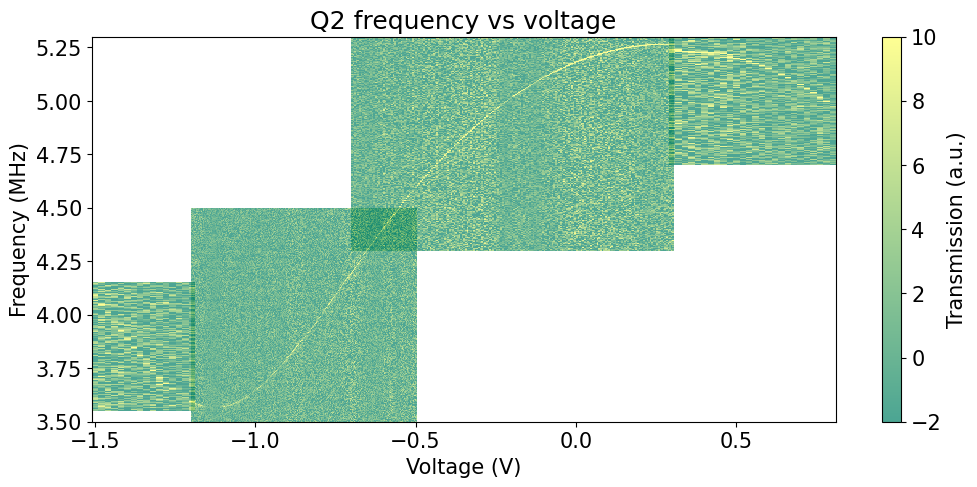

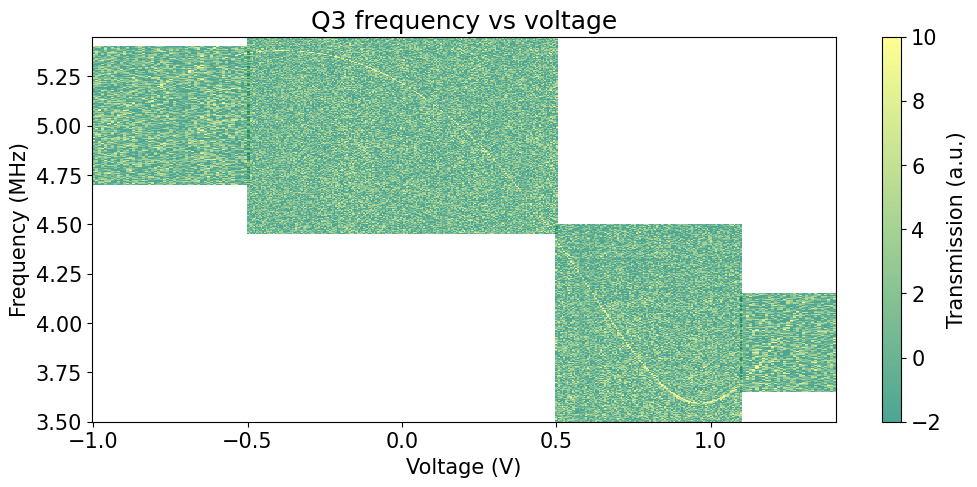

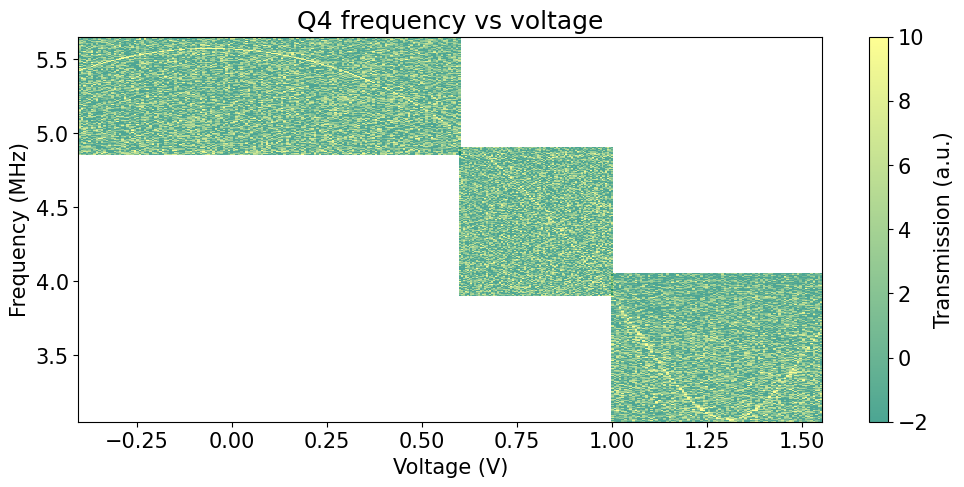

In [564]:
for qubit in qubits:
    voltage_data_all = qubit_to_voltage_data_all[qubit]
    frequency_data_all = qubit_to_frequency_data_all[qubit]
    transmission_data_all = qubit_to_transmission_data_all[qubit]
    
    if len(voltage_data_all) > 0:
        plot_spec_data(voltage_data_all, frequency_data_all, transmission_data_all, qubit_name=qubit)


# 2. Find Peaks

### 2.1 Fit to Lorentzian

In [383]:
def lorentzian_fit(x, x0, a, b, c):
    return a/(b+np.power((x-x0), 2))+c

In [384]:
def get_center_frequencies(voltage_data, frequency_data, transmission_data, start_index=5, voltage_span=100, plot_fits=False):
    '''
    :param voltage_span: number of voltage points around peak to try fit
    '''
    
#     center_frequencies = np.zeros(voltage_data.shape[1])
#     center_frequency_errors = np.zeros(voltage_data.shape[0])
    center_frequencies = []
    center_frequency_errors = []
    voltage_points_with_fit = []
    
    voltages = voltage_data[0,:]
    
    if isinstance(start_index, int):
        start_indices = [start_index] * len(voltages)
    else:
        start_indices = list(start_index)
    
    for i in range(len(voltages)):
        
#         print(f'index: {i}')
        
        frequencies = frequency_data[:,0]
        # find peak
        if i >= len(start_indices):
            start_index = start_indices[-1]
        else:
            start_index = start_indices[i]
        row = transmission_data[start_index:,i]
        
        peak_index = np.argmax(row) + start_index
        center_frequency_guess = frequencies[peak_index]
        
        
        # fit to lorentzian
        # restrict fit in range span around peak

        restricted_frequencies = frequencies[max(peak_index - voltage_span//2, 0):min(peak_index + voltage_span//2, len(frequencies))]
        restricted_row = transmission_data[max(peak_index - voltage_span//2, 0):min(peak_index + voltage_span//2, len(frequencies)),i]
        
        # apply savgol filter
        
        filtered_row = savgol_filter(restricted_row, 7, 1)
        
        bounds = ([restricted_frequencies[0], 0, 0, -np.inf], [restricted_frequencies[-1], np.inf, np.inf, np.inf])
        initial_guess = [center_frequency_guess, 0.001, 0.0001, 0]
        try:
            popt, pcov = curve_fit(lorentzian_fit, restricted_frequencies, filtered_row, p0=initial_guess, bounds=bounds)
        except:
            # if it fails, plot the data it was trying to fit
            plt.plot(restricted_frequencies, filtered_row, linestyle='', marker='o', label='data')
            plt.plot(restricted_frequencies, lorentzian_fit(restricted_frequencies, *initial_guess), label='guess')
            plt.xlabel('Frequency (MHz)')
            plt.title(f'Lorentzian fit for index {i}')
            plt.axvline(center_frequency_guess, color='red')
            plt.legend()
            plt.show()
            
            print('Couldn\'t get a fit')
            
            # use max as the center frequency
            center_frequencies.append(restricted_frequencies[np.argmax(filtered_row)])
            voltage_points_with_fit.append(voltages[i])
            center_frequency_errors.append(frequencies[-1] - frequencies[0])
            
            
        else:
            
            center_frequencies.append(popt[0])

            perr = np.sqrt(np.diag(pcov))
            center_frequency_errors.append(perr[0])

            voltage_points_with_fit.append(voltages[i])
            
            if plot_fits:
                plt.plot(frequencies[start_index:], row, linestyle='', marker='o', label='data')

                fit_frequencies = np.linspace(frequencies[start_index], frequencies[-1], 1000)
                plt.plot(fit_frequencies, lorentzian_fit(fit_frequencies, *popt), label='fit')
                plt.axvline(center_frequency_guess, color='red')
                plt.legend()

                plt.xlabel('Frequency (MHz)')
                plt.title(f'Lorentzian fit for index {i}')
                plt.show()

                print(f'Center frequency is {popt[0]} MHz')
            
    return voltage_points_with_fit, center_frequencies, center_frequency_errors


In [567]:
qubit_to_voltages = {}
qubit_to_frequencies = {}

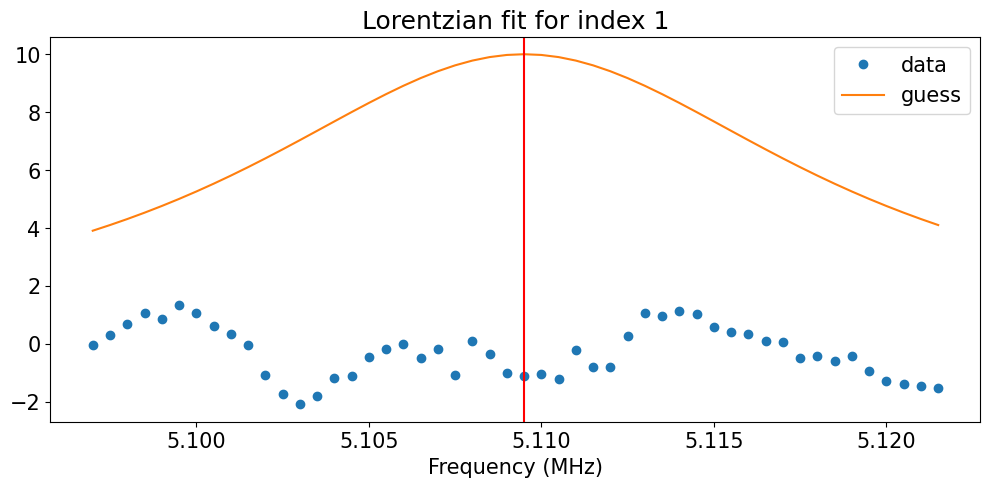

Couldn't get a fit


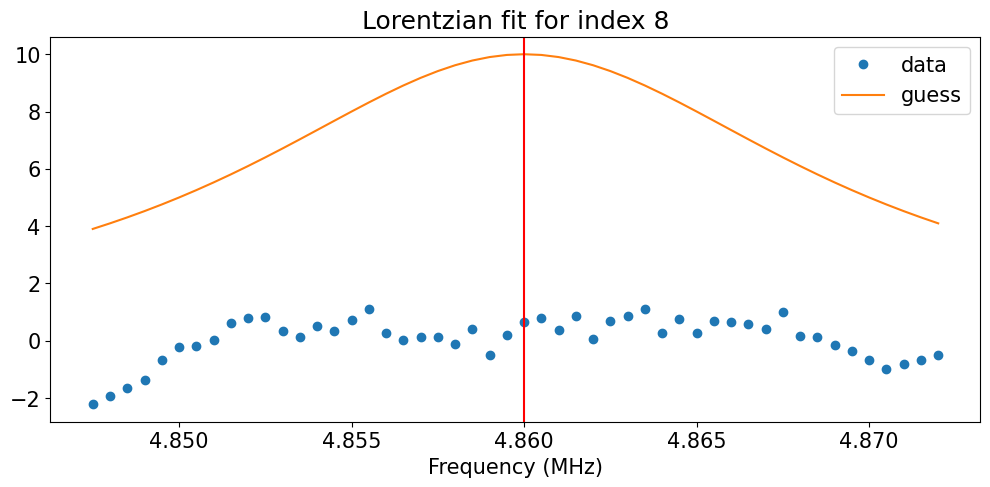

Couldn't get a fit


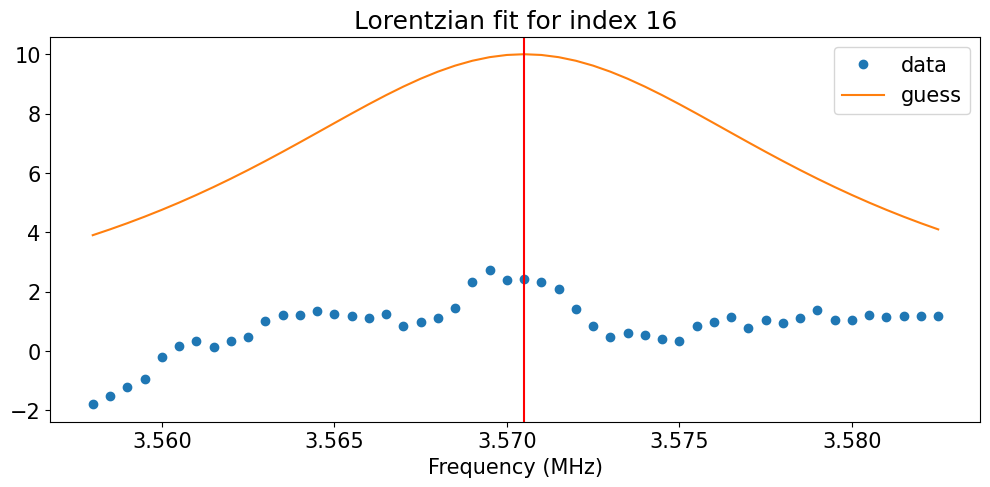

Couldn't get a fit


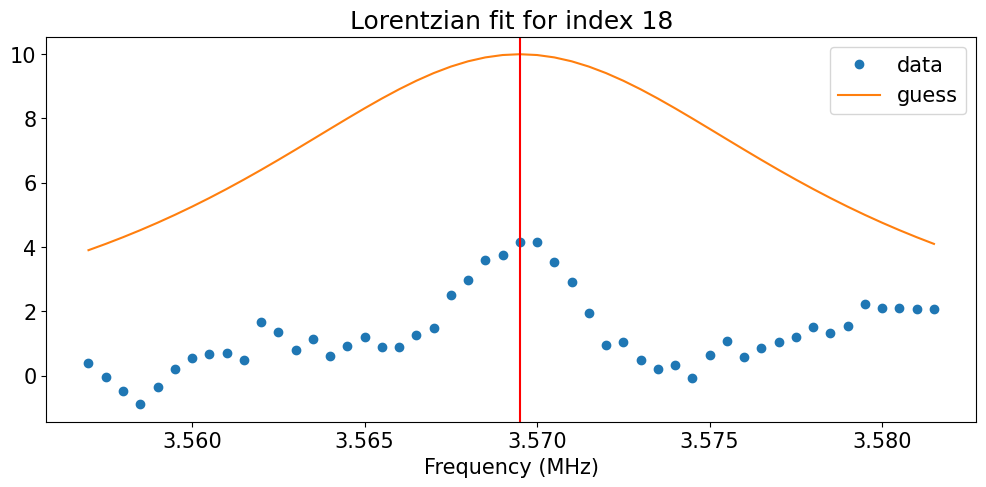

Couldn't get a fit


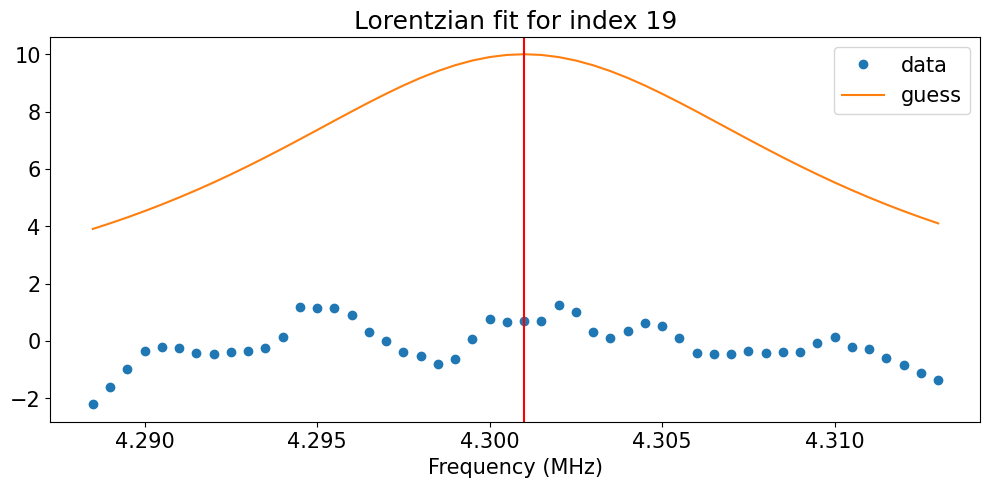

Couldn't get a fit


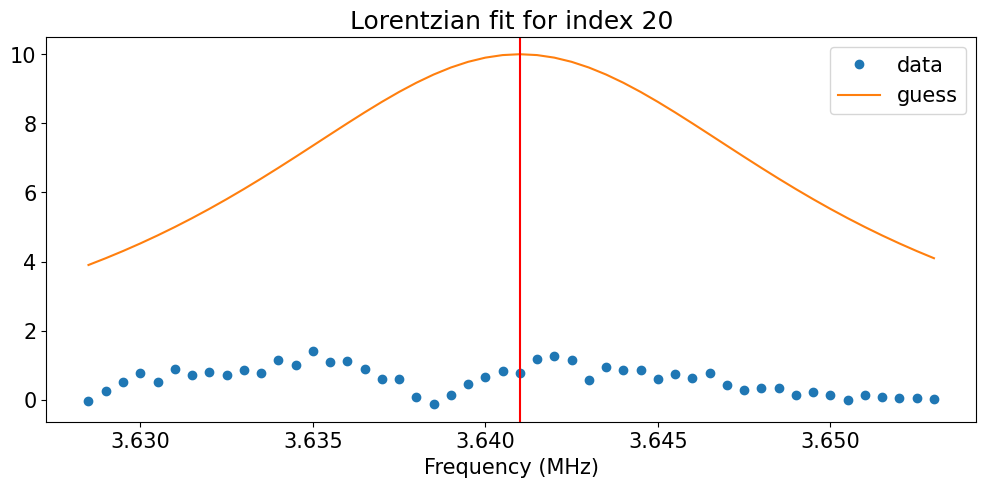

Couldn't get a fit


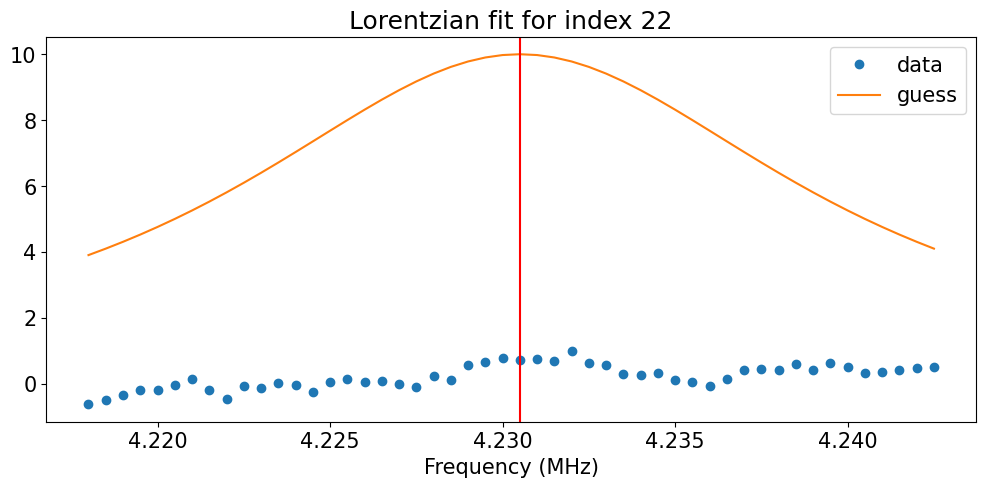

Couldn't get a fit


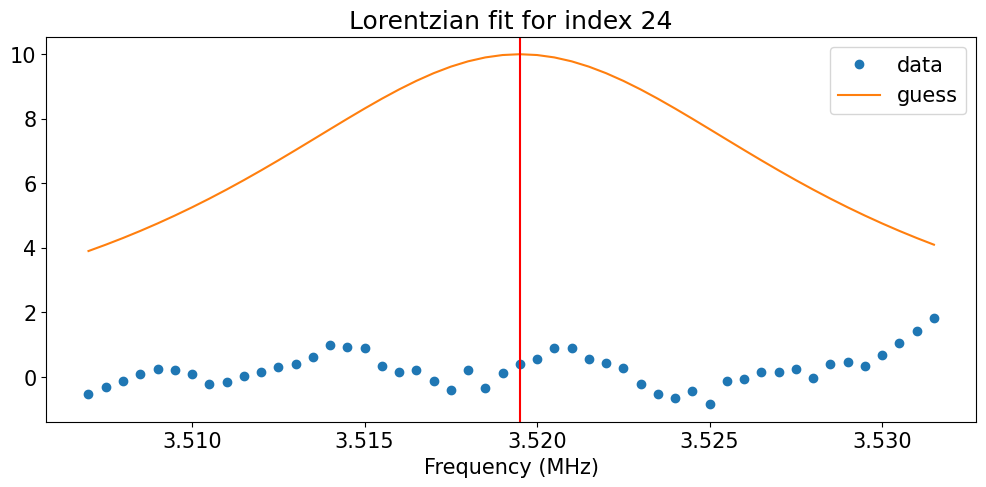

Couldn't get a fit


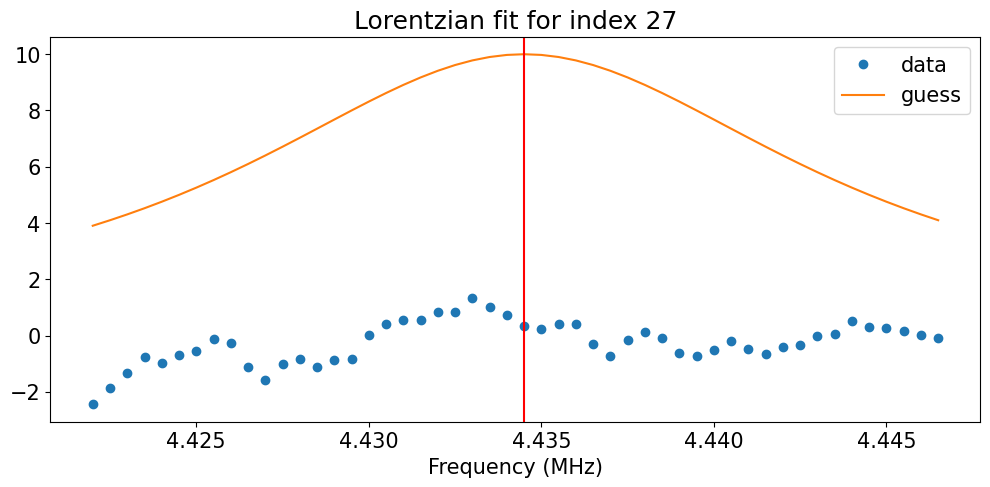

Couldn't get a fit


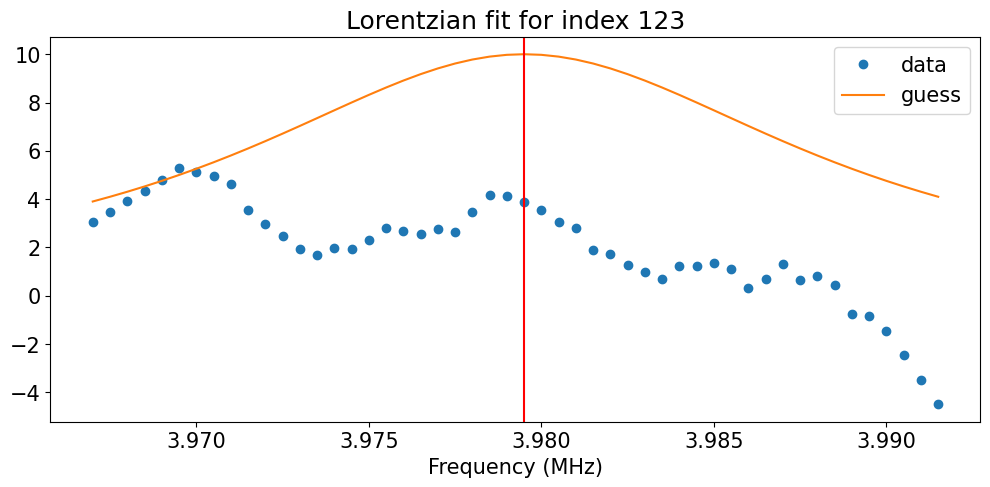

Couldn't get a fit


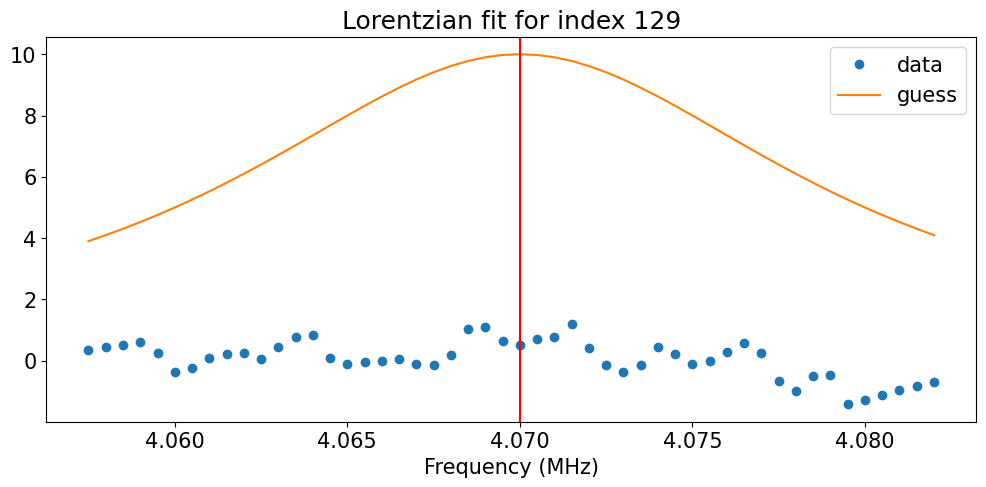

Couldn't get a fit


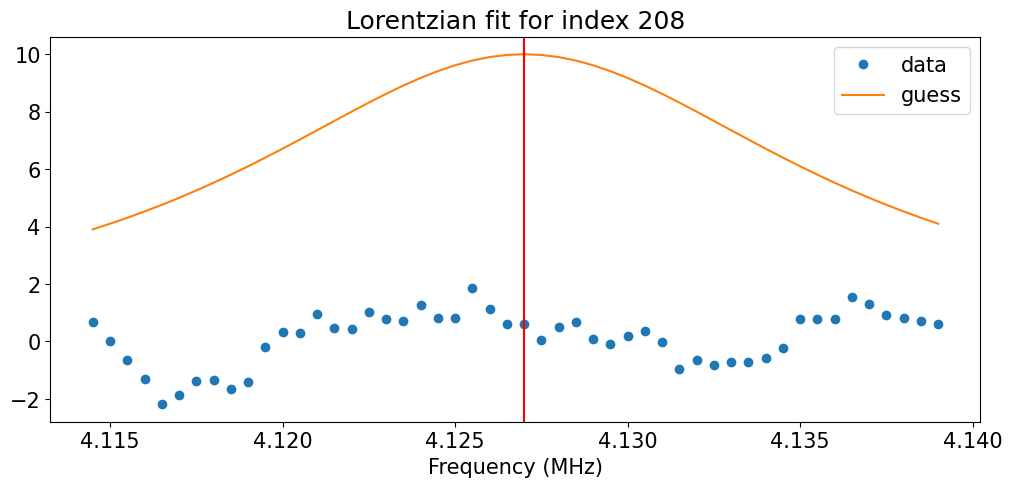

Couldn't get a fit


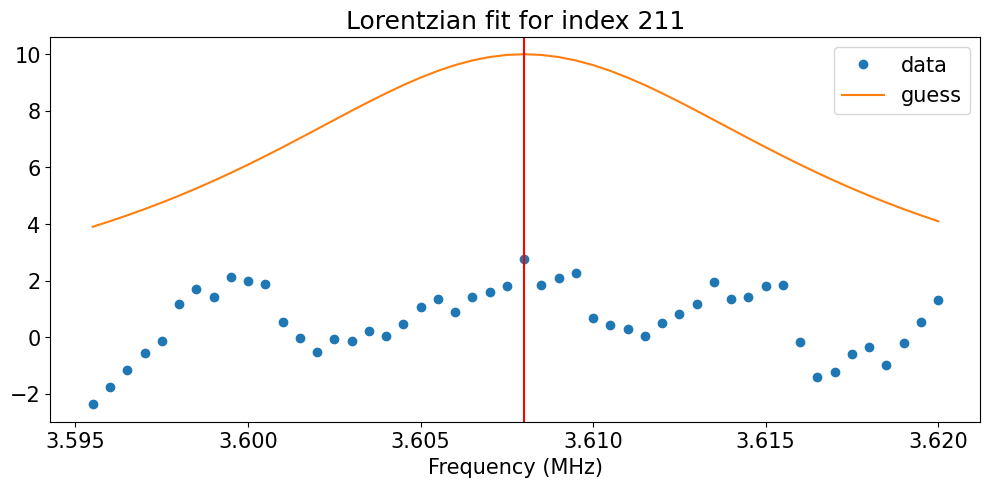

Couldn't get a fit


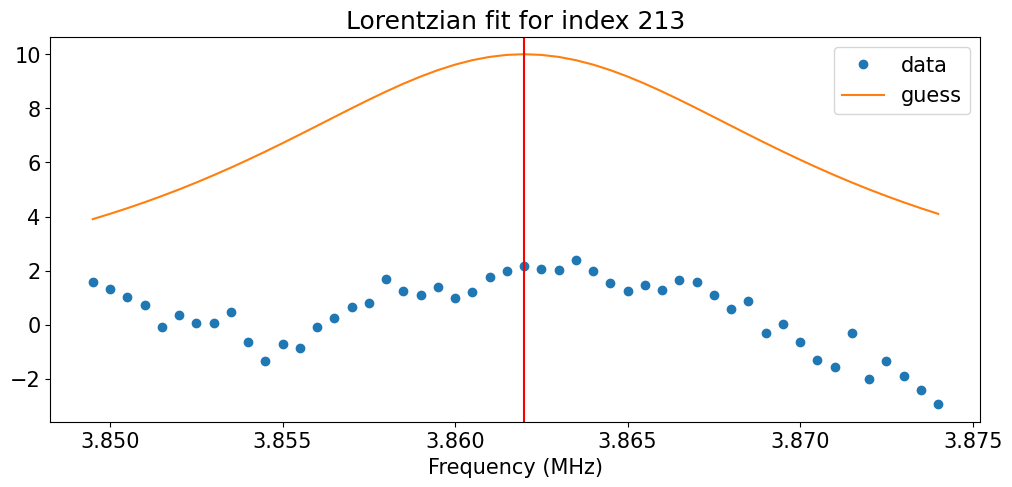

Couldn't get a fit


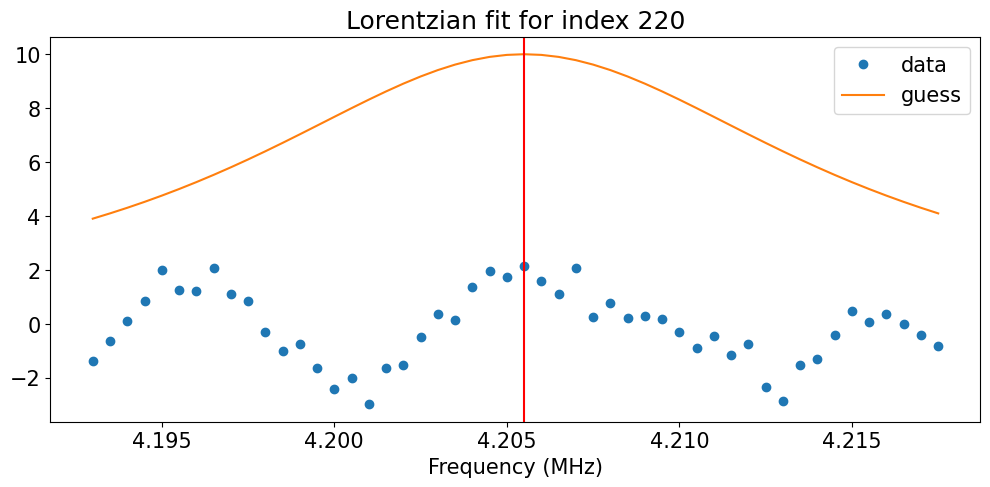

Couldn't get a fit


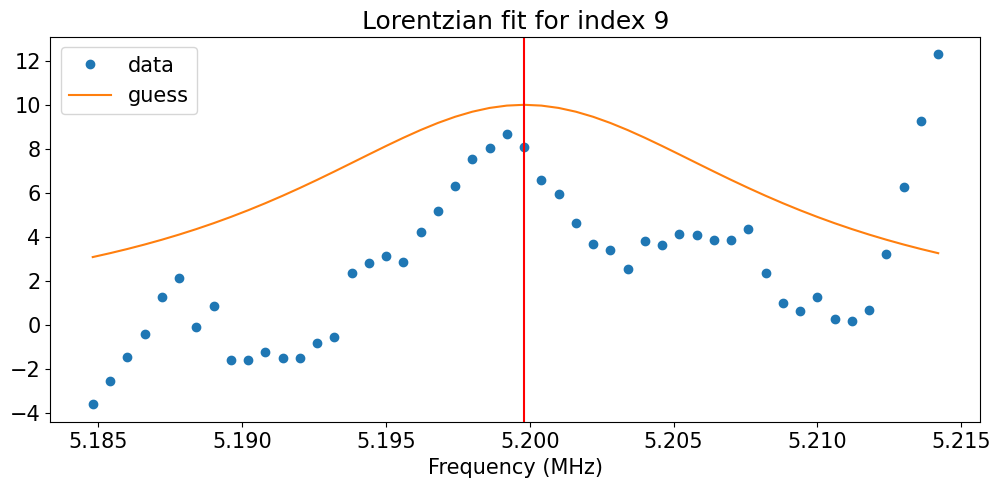

Couldn't get a fit


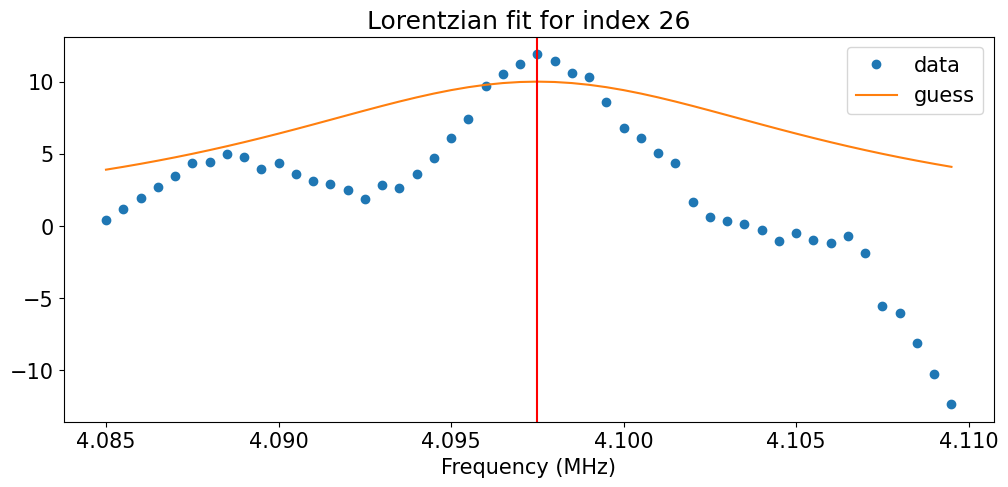

Couldn't get a fit


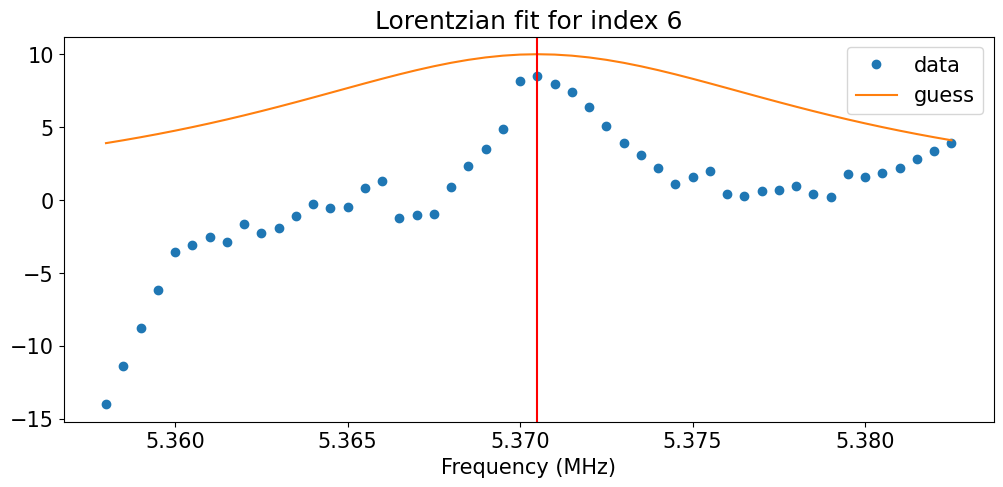

Couldn't get a fit


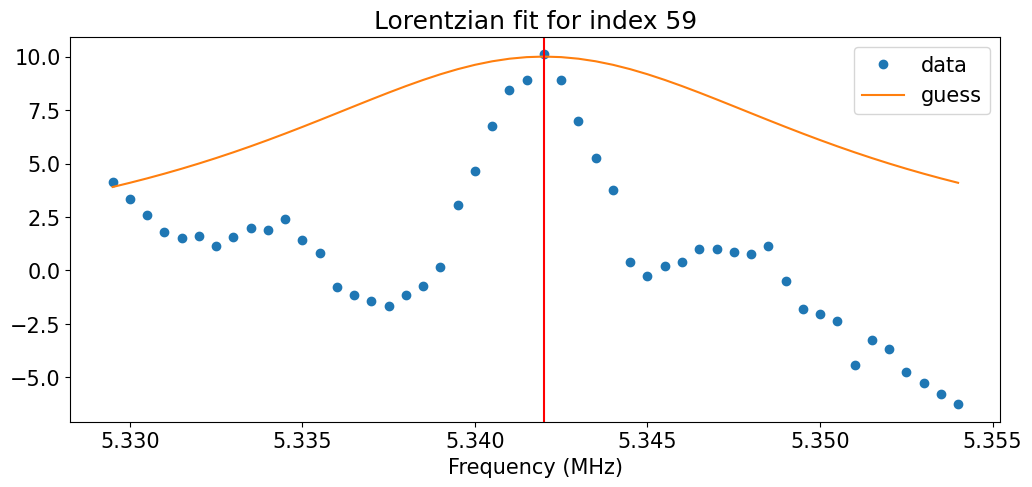

Couldn't get a fit


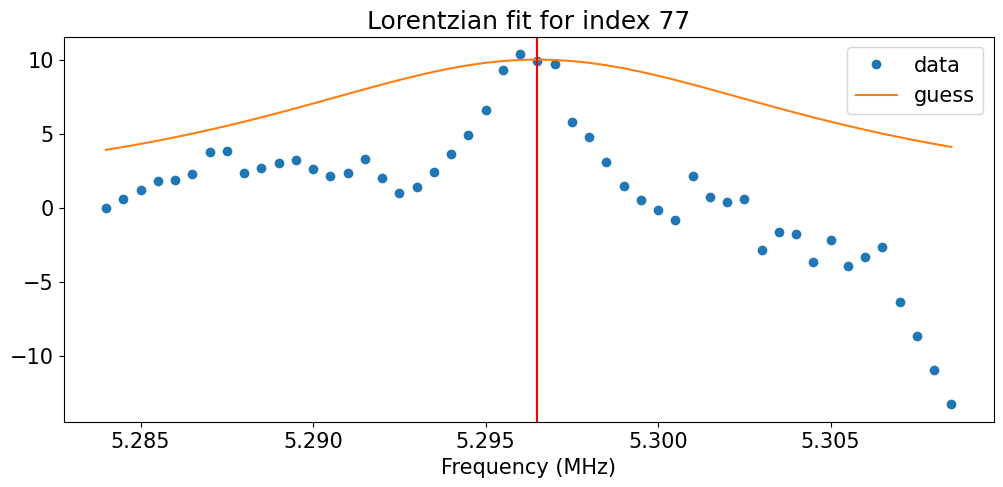

Couldn't get a fit


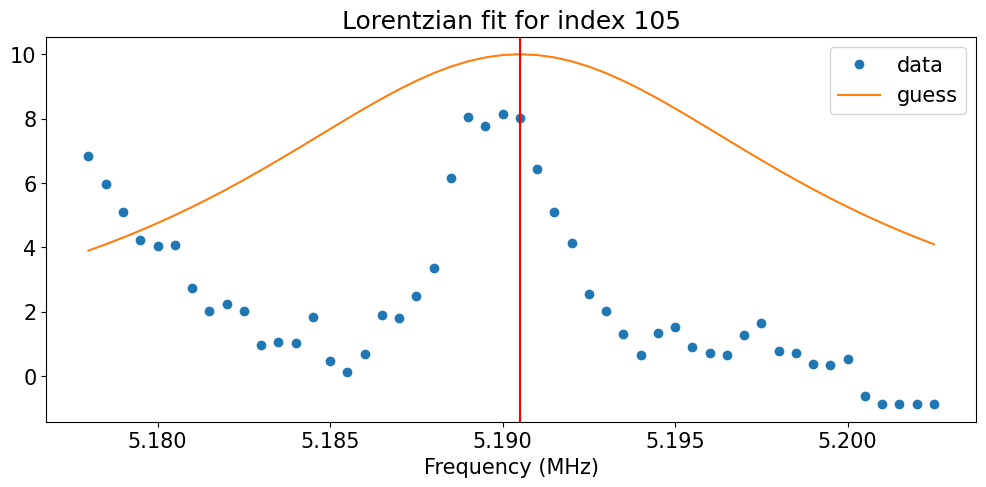

Couldn't get a fit


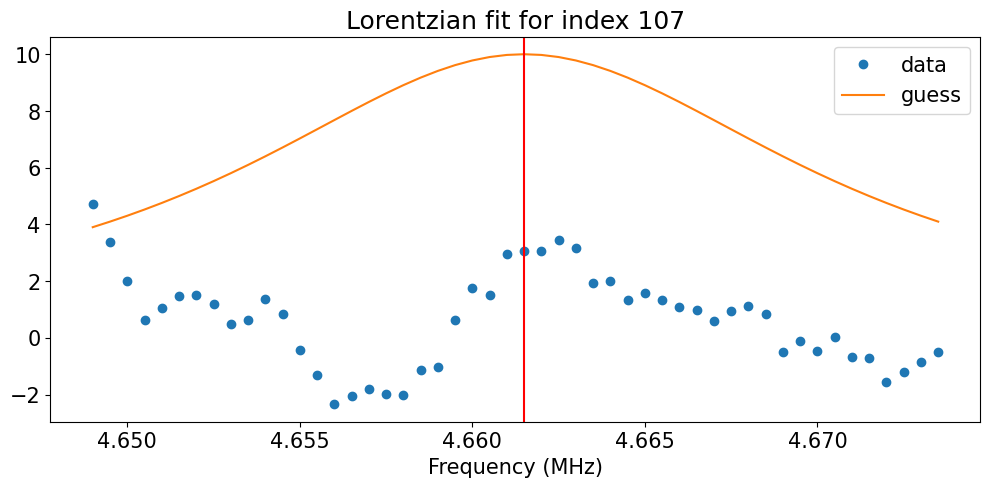

Couldn't get a fit


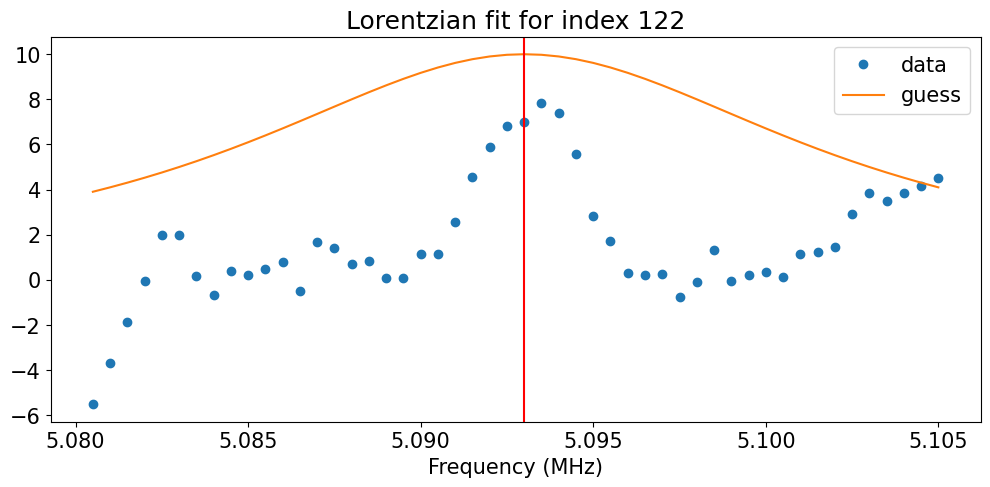

Couldn't get a fit


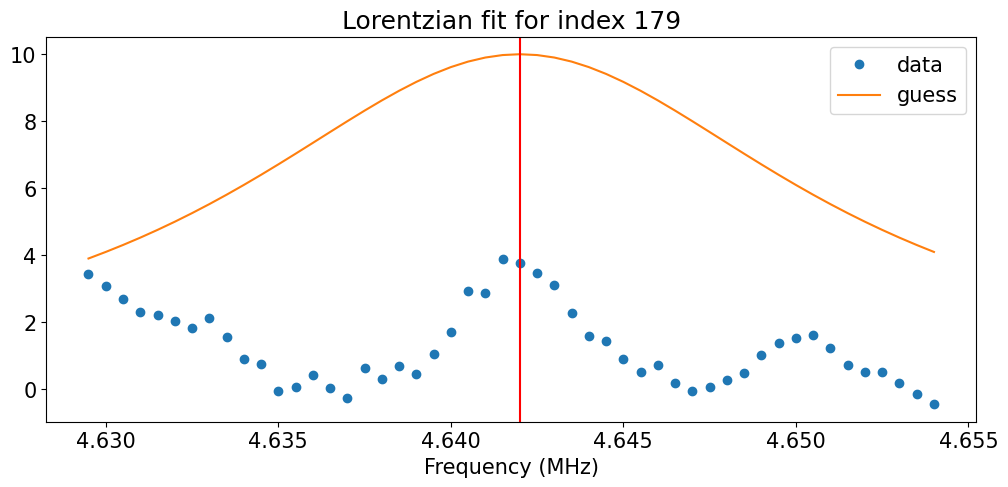

Couldn't get a fit


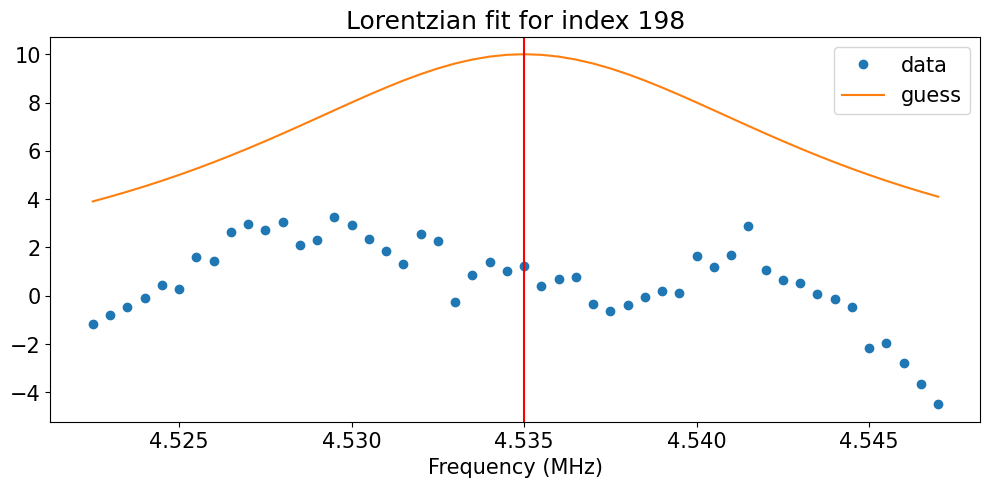

Couldn't get a fit


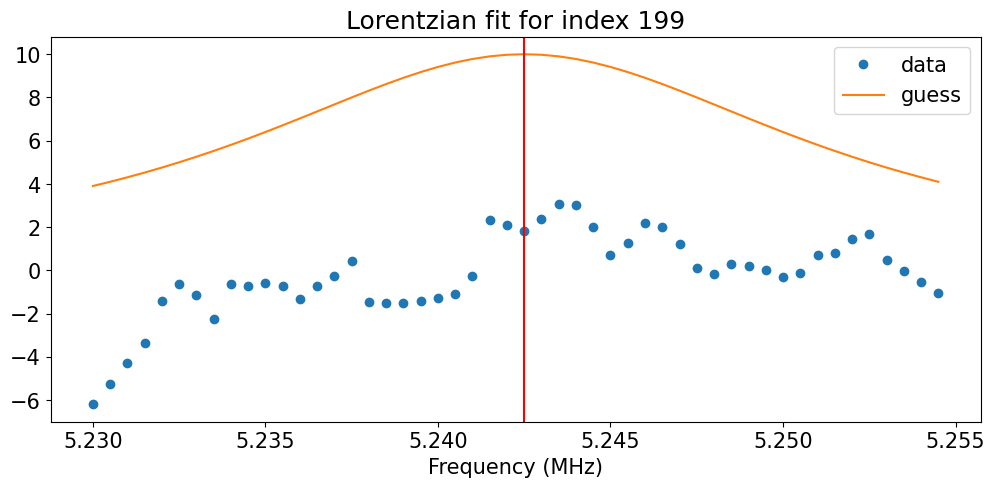

Couldn't get a fit


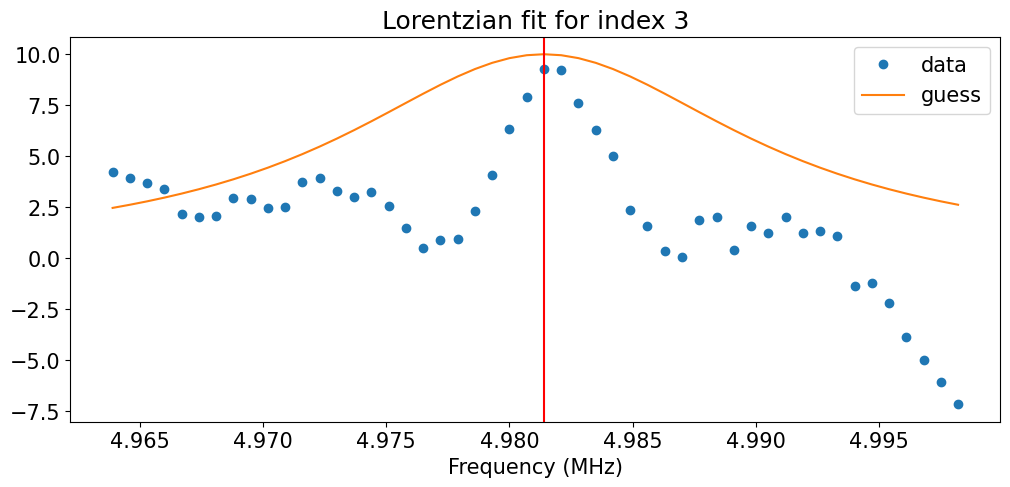

Couldn't get a fit


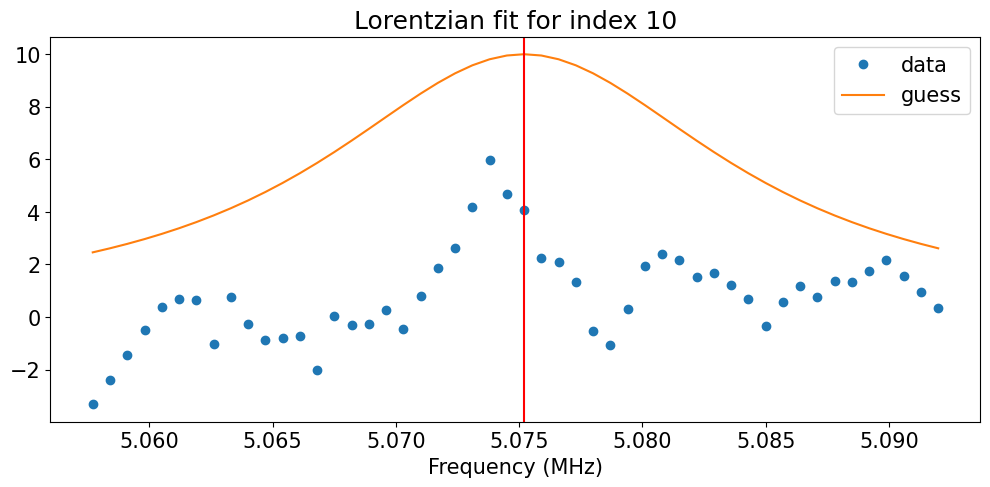

Couldn't get a fit


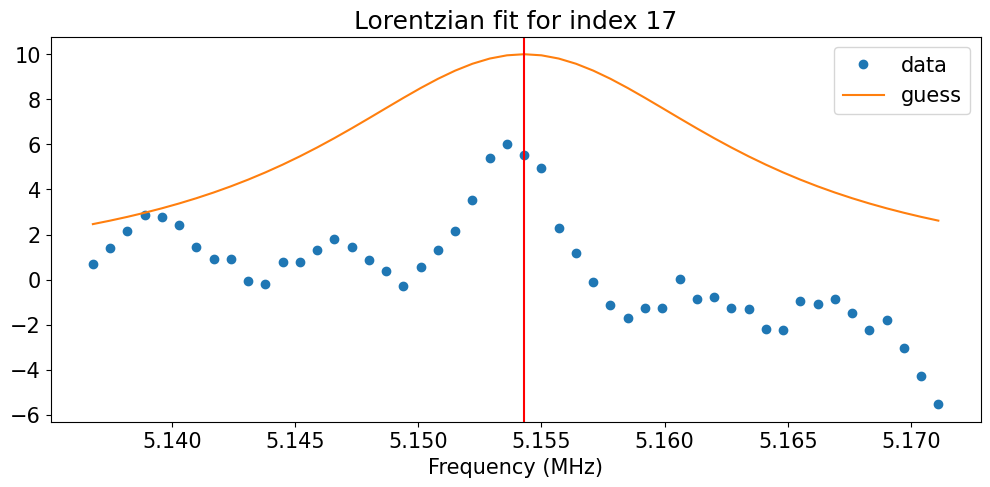

Couldn't get a fit


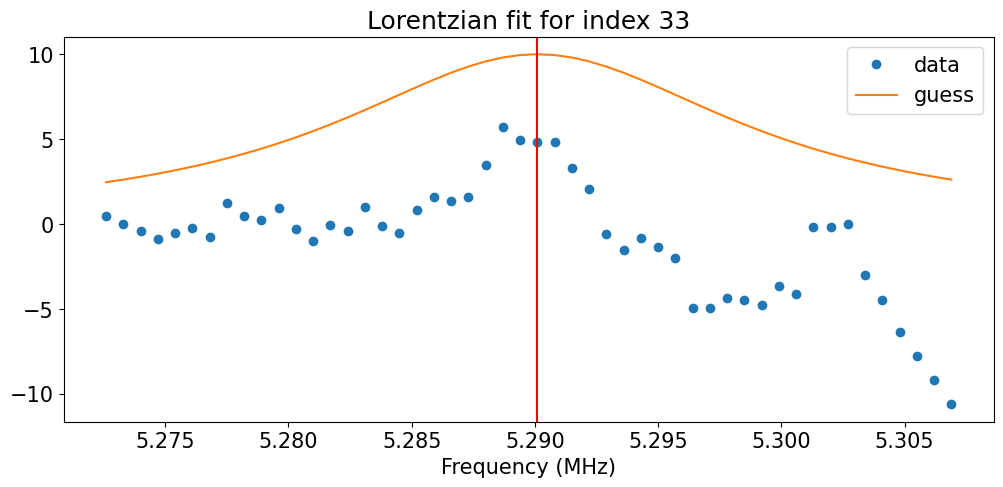

Couldn't get a fit


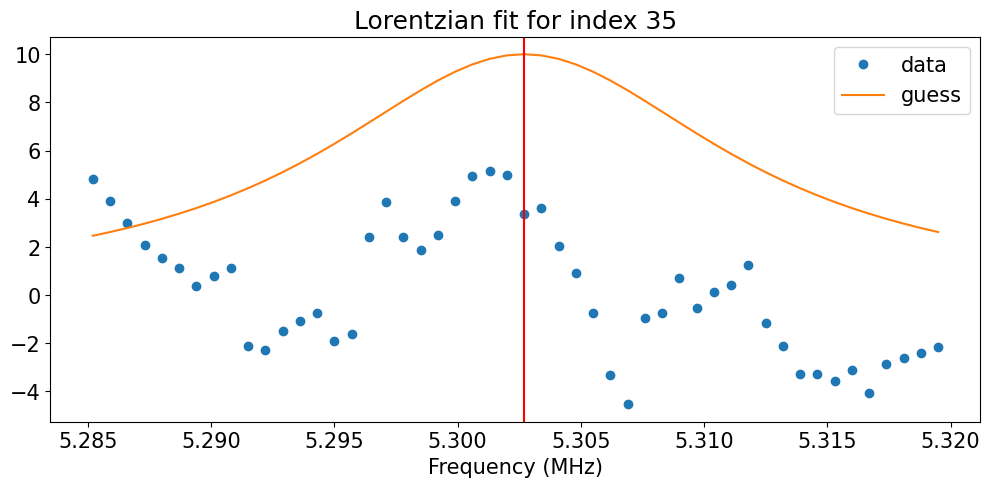

Couldn't get a fit


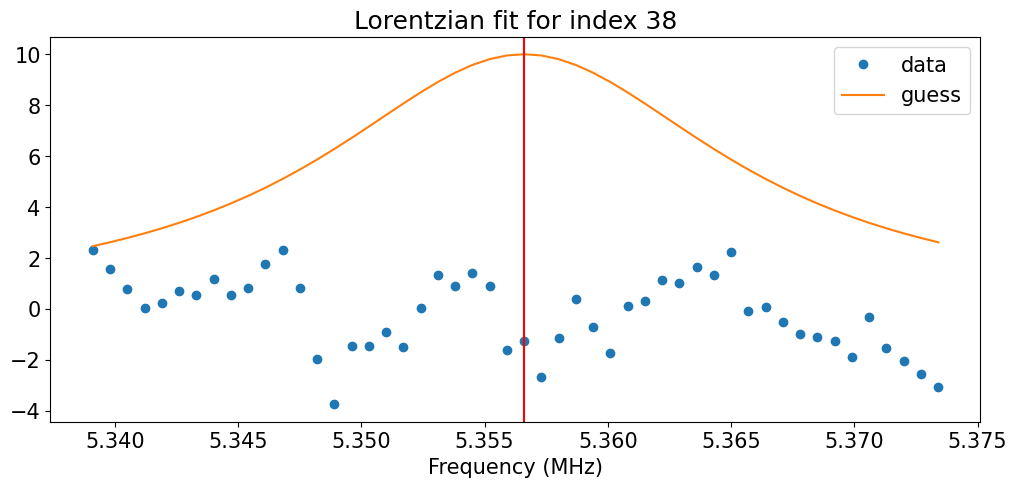

Couldn't get a fit


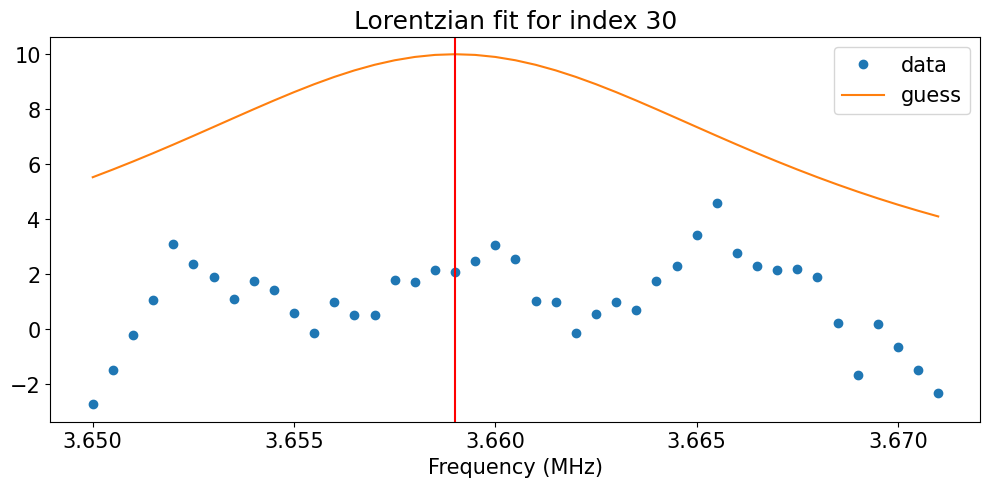

Couldn't get a fit


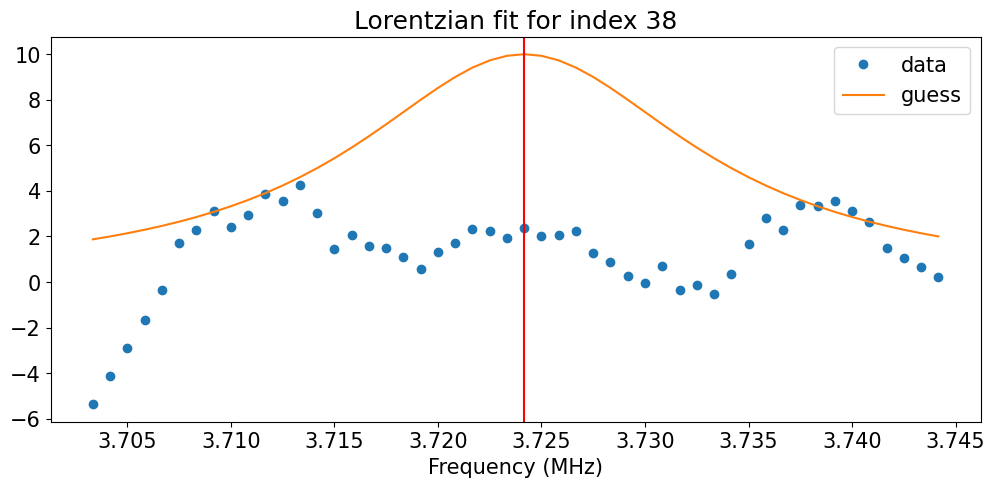

Couldn't get a fit


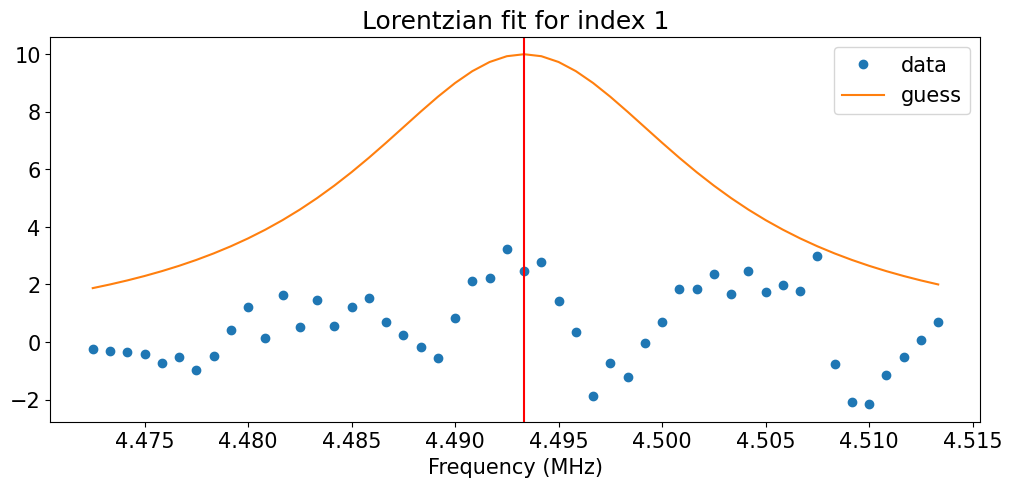

Couldn't get a fit


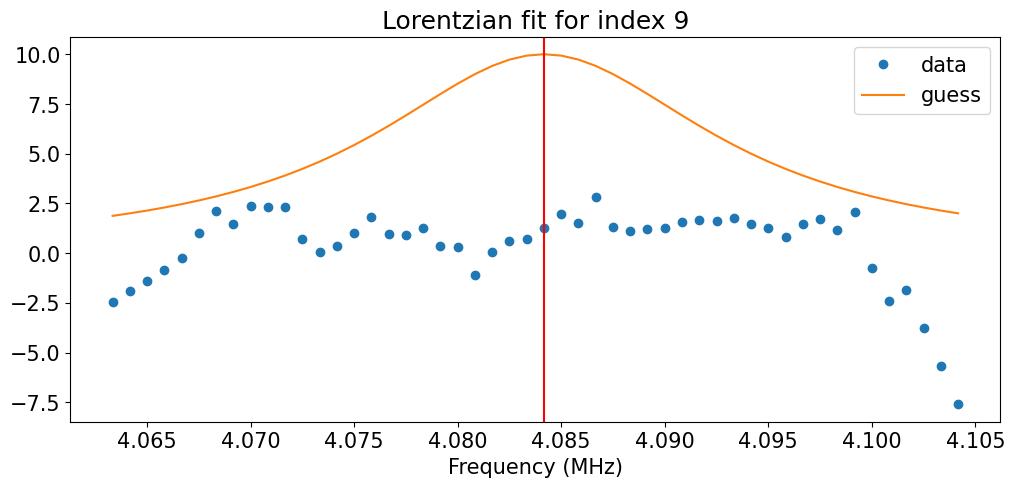

Couldn't get a fit


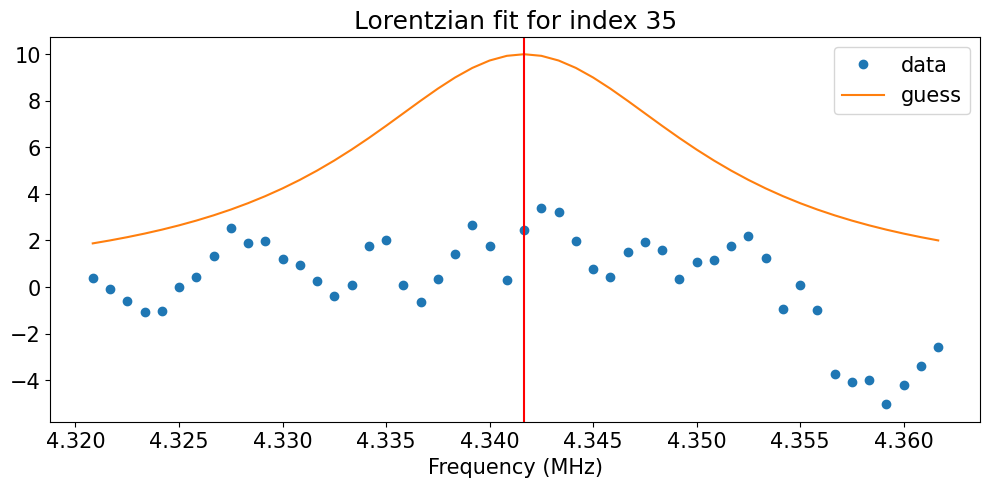

Couldn't get a fit


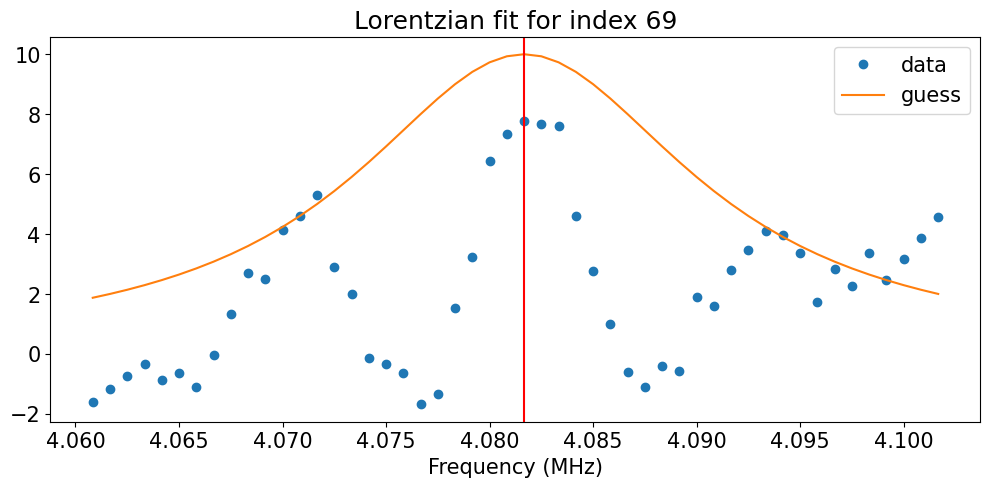

Couldn't get a fit


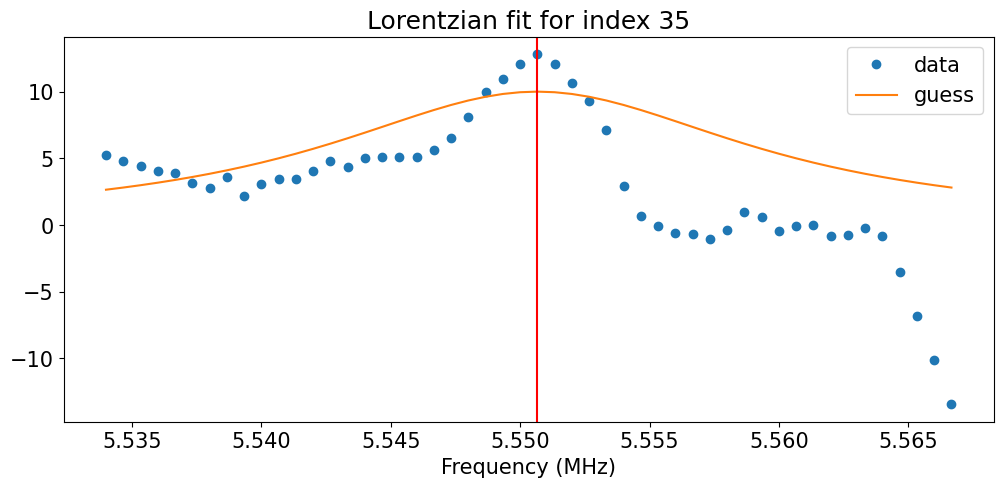

Couldn't get a fit


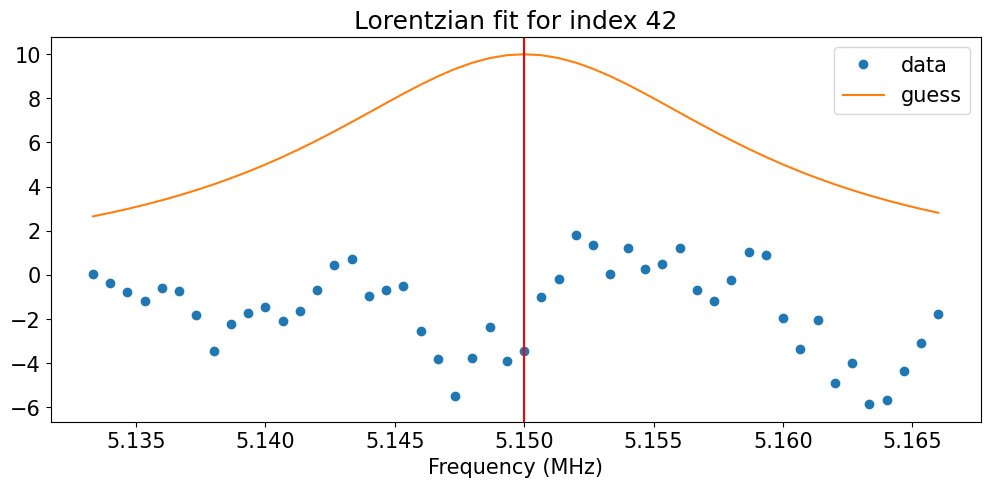

Couldn't get a fit


In [568]:
rescan_qubits = ['Q2', 'Q3', 'Q4']
rescan_qubits = ['Q2']

for qubit in rescan_qubits:
    voltages = []
    center_frequencies = []
    center_frequency_errors = []

    plot_fits = False
    plot_as_flux=True
    plot_as_flux=False

    for file in qubit_to_spec_filenames[qubit]:
        voltage_data, frequency_data, transmission_data = get_data(file)
        start_index = 5
    #     filename = filepath.split('\\')[-1]
    #     if filename == filename4:
    #         start_index = [13, 1, 13, 9, 7, 5, 4, 1, 1, 1, 
    #                        1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    #                        1, 1, 2, 4, 8, 10, 12, 21, 14, 15,
    #                        17]
    #     elif filename == filename5:
    #         start_index = [1, 13, 9, 7, 4, 2, 1, 1, 1, 1, 
    #                        1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    #                        1, 2, 5, 7, 9, 12, 1, 13, 15, 17,
    #                        19]


        voltage_span = 50

    #     file_voltages, file_frequencies, error = get_center_frequencies(voltage_data, frequency_data, transmission_data, start_index, plot_fits=plot_fits, plot_center_frequencies=True, show_plot=False, plot_as_flux=plot_as_flux)
        file_voltages, file_frequencies, error = get_center_frequencies(voltage_data, frequency_data, transmission_data, start_index, voltage_span=voltage_span, plot_fits=plot_fits)

        voltages.extend(file_voltages)
        center_frequencies.extend(file_frequencies)
        center_frequency_errors.extend(error)

    voltages = np.array(voltages)
    center_frequencies = np.array(center_frequencies)
    center_frequency_errors = np.array(center_frequency_errors)

    plt.show()

    # sort data by voltage

    sorted_indices = voltages.argsort()
    voltages = voltages[sorted_indices]
    center_frequencies = center_frequencies[sorted_indices]
    center_frequency_errors = center_frequency_errors[sorted_indices]
    
    qubit_to_voltages[qubit] = voltages
    qubit_to_frequencies[qubit] = center_frequencies


### 2.2 Plot Results

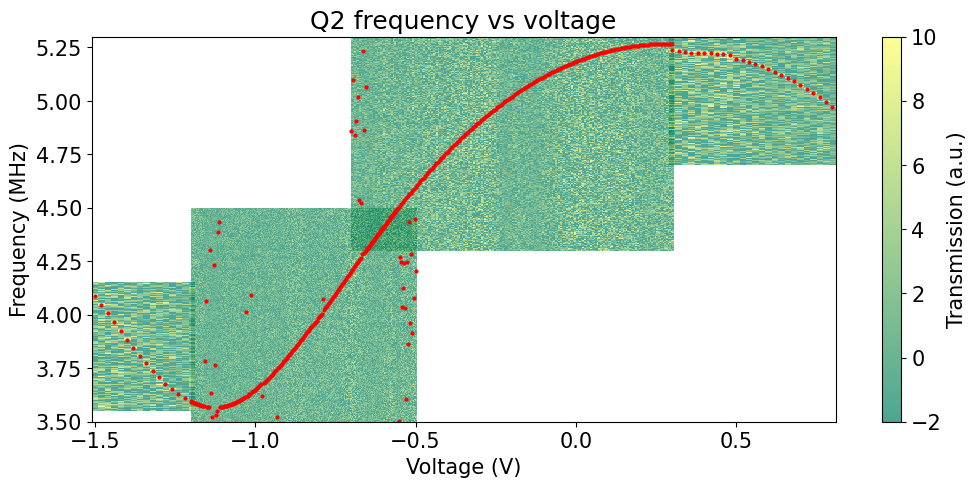

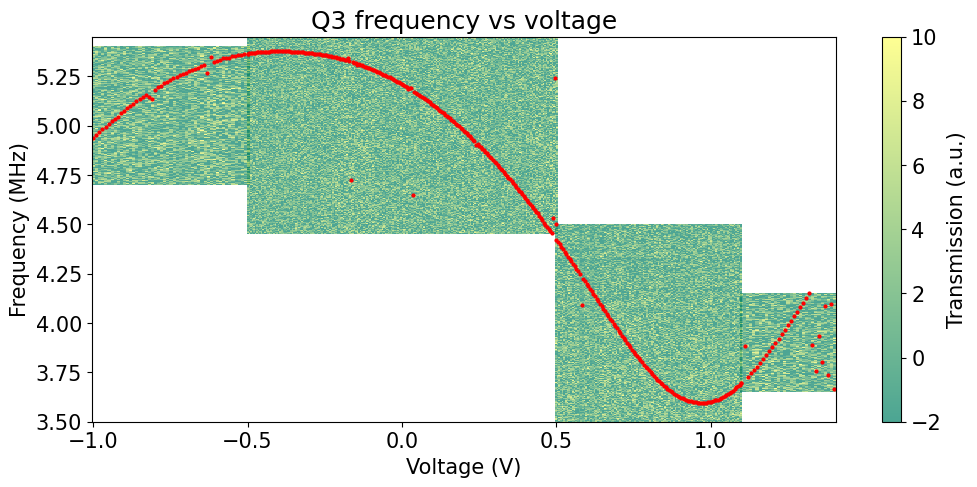

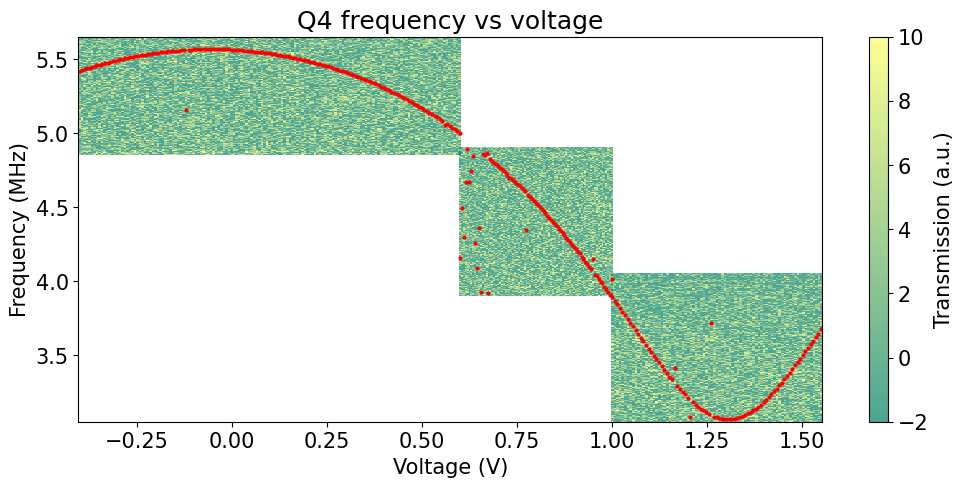

In [569]:
### plot spec data with center frequencies
for qubit in qubits:
    voltage_data_all = qubit_to_voltage_data_all[qubit]
    frequency_data_all = qubit_to_frequency_data_all[qubit]
    transmission_data_all = qubit_to_transmission_data_all[qubit]
    
    if len(voltage_data_all) > 0:

        voltages = qubit_to_voltages[qubit]
        frequencies = qubit_to_frequencies[qubit]

        plot_spec_data(voltage_data_all, frequency_data_all, transmission_data_all, fit_voltages=voltages, fit_frequencies=frequencies, qubit_name=qubit)


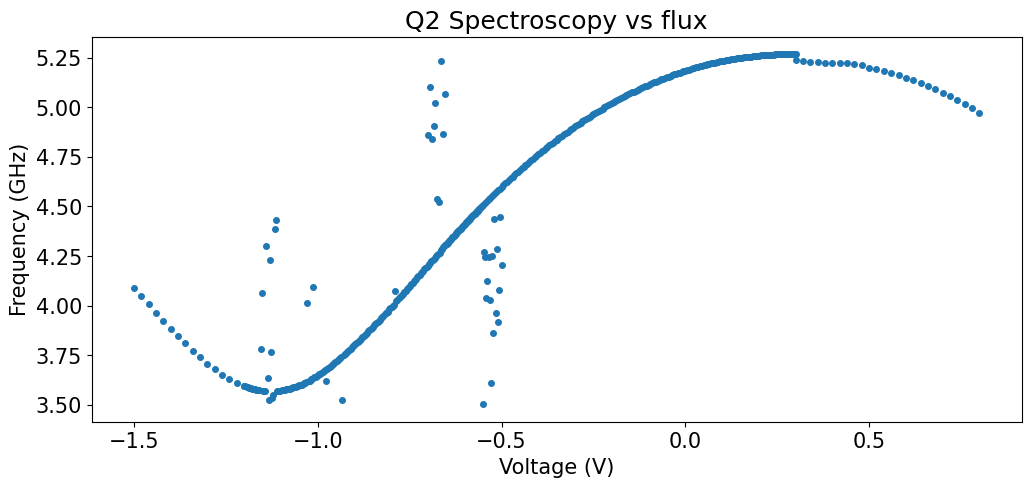

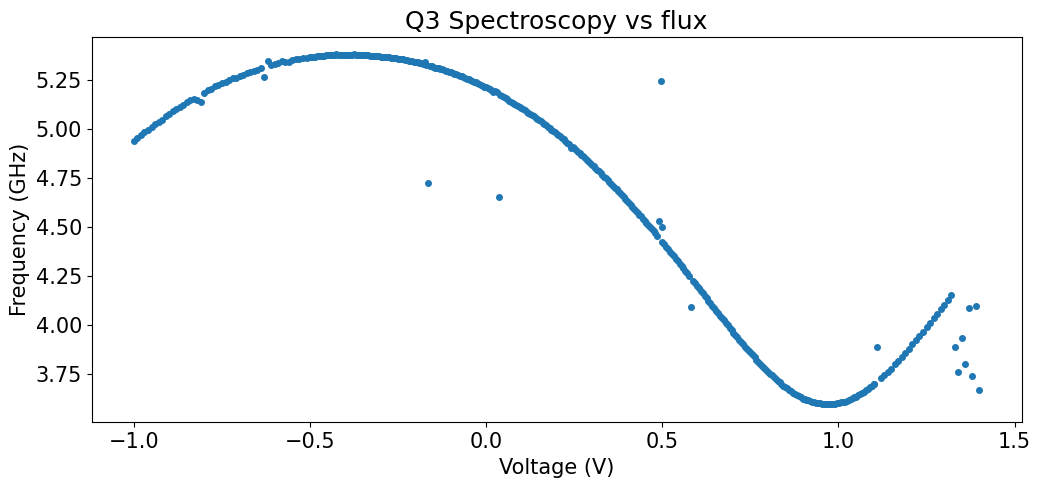

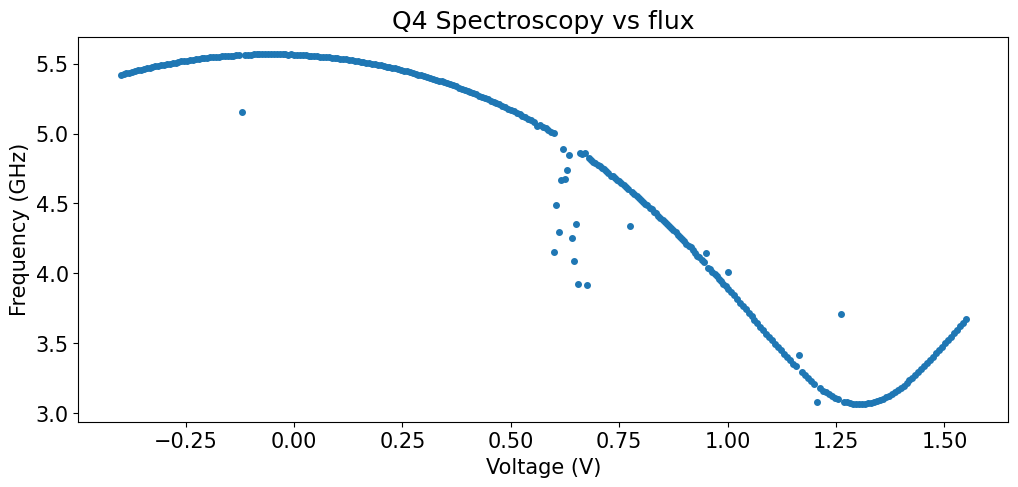

In [573]:
for qubit in qubits:
    if qubit in qubit_to_frequencies and qubit in qubit_to_voltages: 
        
        voltages = qubit_to_voltages[qubit]
        frequencies = qubit_to_frequencies[qubit]
        
        if len(frequencies) > 0:

            plt.plot(voltages, frequencies, marker='o', linestyle='', ms=4)

            plt.xlabel('Voltage (V)')
            plt.ylabel('Frequency (GHz)')

            plt.title(f'{qubit} Spectroscopy vs flux')

            plt.show()

### 2.3 Find points to ignore

In [900]:
qubit_to_filtered_voltages = {}
qubit_to_filtered_frequencies = {}

qubit_to_ignore_indices_expanded = {}

In [1084]:
'''
define indices to ignore as list of indices
each element is an index or a tuple of index
if index, add that index to set of indices to ignore
if tuple (i1, i2), add the range [i1, i2) to the set of indices to ignore 
'''

qubit_to_ignore_indices = {}

qubit_to_ignore_indices['Q1'] = []

qubit_to_ignore_indices['Q2'] = [30, 31, (35, 40), 42, 43, 70, 75, 86, 100, 145, 174, 176, 179, 181, 184, 187, 189, 192, 194, 
                                 197, 250, 252, 254, 255, 257, 258, 260, 262, 263, 265, 267, 268, 270, 272, 273, 275, 276,
                                (437, 450)]

qubit_to_ignore_indices['Q3'] = [118, 158, 250, 267, 364, (386, 394)]

qubit_to_ignore_indices['Q4'] = [42, (151, 163), 166, 186, 221, 231, 256, 262, 270]


313
{256, 262, 270, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 166, 42, 186, 221, 231}


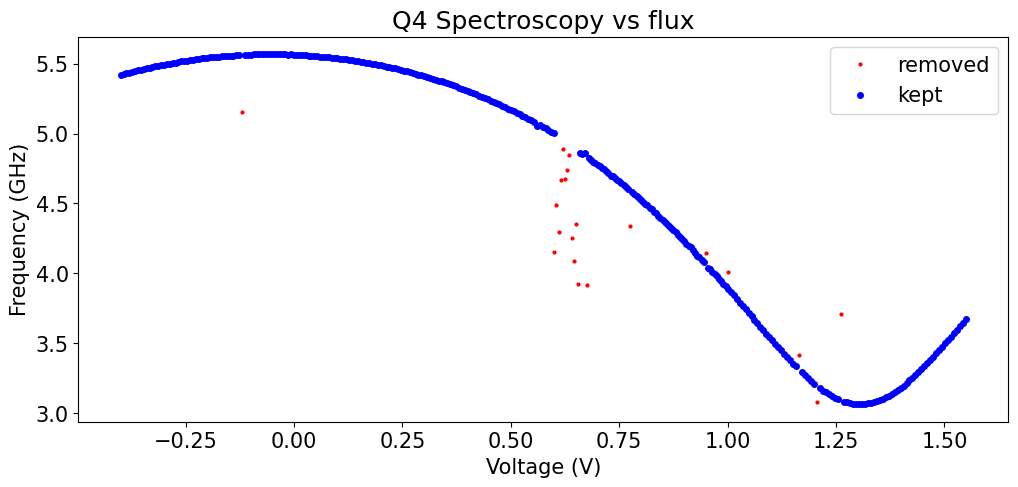

In [1086]:
filter_qubits = ['Q4']

for qubit in filter_qubits:
    if qubit in qubit_to_frequencies and qubit in qubit_to_voltages: 
        
        voltages = qubit_to_voltages[qubit]
        frequencies = qubit_to_frequencies[qubit]
        
        if len(frequencies) > 0:
            print(len(qubit_to_voltages[qubit]))
            
            ignore_indices = qubit_to_ignore_indices[qubit]

            # expand tuple ranges into their explicit set of indices
            ignore_indices_expanded = set()

            for i in range(len(ignore_indices)):
                ignore_index = ignore_indices[i]
                if isinstance(ignore_index, int):
                    ignore_indices_expanded.add(ignore_index)
                elif isinstance(ignore_index, (tuple, list)):
                    ignore_indices_expanded.update(range(ignore_index[0], ignore_index[1]))
                    
                    

            inverse_ignore_indices = set(range(len(voltages))) - ignore_indices_expanded
            inverse_ignore_indices = list(inverse_ignore_indices)
            
            qubit_to_ignore_indices_expanded[qubit] = list(ignore_indices_expanded)
            
            qubit_to_filtered_voltages[qubit] = np.copy(voltages)[inverse_ignore_indices]
            qubit_to_filtered_frequencies[qubit] = np.copy(frequencies)[inverse_ignore_indices]
            
            print(ignore_indices_expanded)
            
            
            plt.plot(voltages[list(ignore_indices_expanded)], frequencies[list(ignore_indices_expanded)], marker='o', linestyle='', ms=2, color='red', label='removed')
            plt.plot(qubit_to_filtered_voltages[qubit], qubit_to_filtered_frequencies[qubit], marker='o', linestyle='', ms=4, color='blue', label='kept')
#             plt.plot(voltages, frequencies, alpha=0)

#             plt.xlim(1.15, 1.4)

            plt.xlabel('Voltage (V)')
            plt.ylabel('Frequency (GHz)')

            plt.legend()

            plt.title(f'{qubit} Spectroscopy vs flux')

            plt.show()           

# 3. Fit Spectrum to Model

### 3.1 Transmon Model

In [1087]:
def frequency_model_fit(x, x0, a, b, c, d):
    return np.sqrt(a*np.sqrt(np.power(np.cos(b*(x-x0)),2) + (d**2)*np.power(np.sin(b*(x-x0)),2))) - c

In [1088]:
# initial guesses
qubit_to_transmon_initial_guess = {}

qubit_to_transmon_initial_guess['Q2'] = [-0.5, 30, 1.2, 0.2, 0.6]
qubit_to_transmon_initial_guess['Q3'] = [-0.5, 30, 1.2, 0.2, 0.6]
qubit_to_transmon_initial_guess['Q4'] = [-0.5, 30, 1.2, 0.2, 0.6]

# bounds
qubit_to_transmon_bounds = {}

qubit_to_transmon_bounds['Q2'] = ((-np.inf, 0, 0, 0.199, 0), (np.inf, np.inf, np.inf, 0.202, 1))
qubit_to_transmon_bounds['Q3'] = ((-np.inf, 0, 0, 0.199, 0), (np.inf, np.inf, np.inf, 0.202, 1))
qubit_to_transmon_bounds['Q4'] = ((-np.inf, 0, 0, 0.199, 0), (np.inf, np.inf, np.inf, 0.202, 1))


In [1089]:
# transmon popts, pcovs
qubit_to_transmon_popts = {}
qubit_to_transmon_pcovs = {}

[ 0.24319931 30.12476583  1.12756666  0.199       0.47494391]


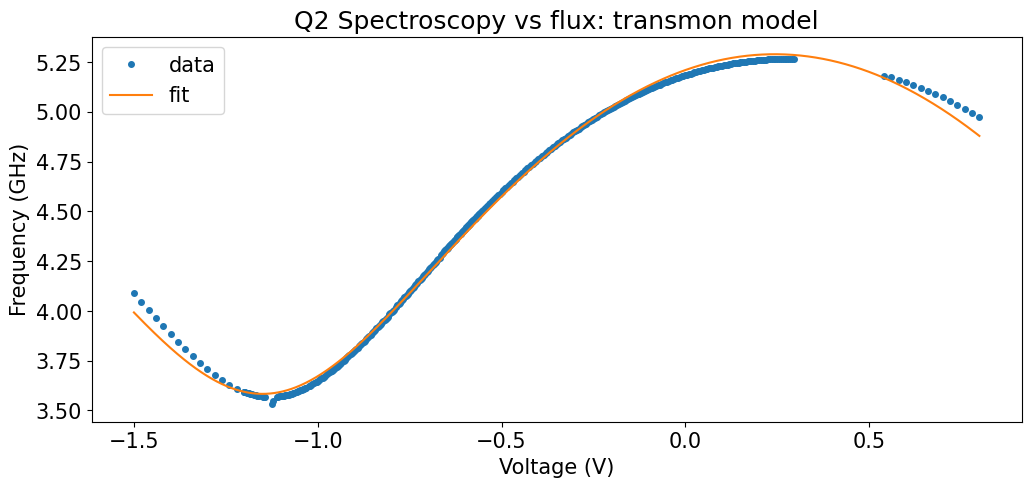

[-0.37206575 31.54499497  1.15220421  0.199       0.46712212]


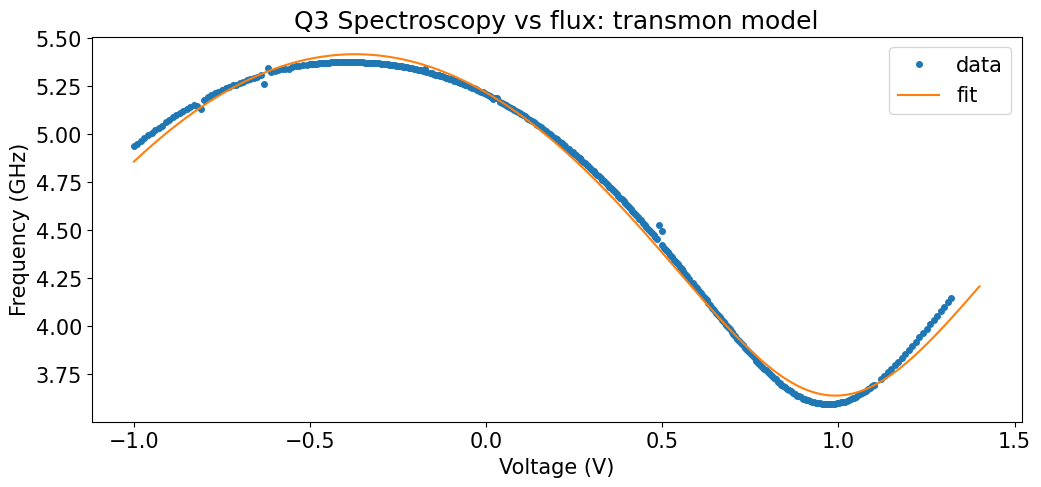

[7.05958572e-03 3.37957709e+01 1.19117465e+00 1.99000000e-01
 3.30542358e-01]


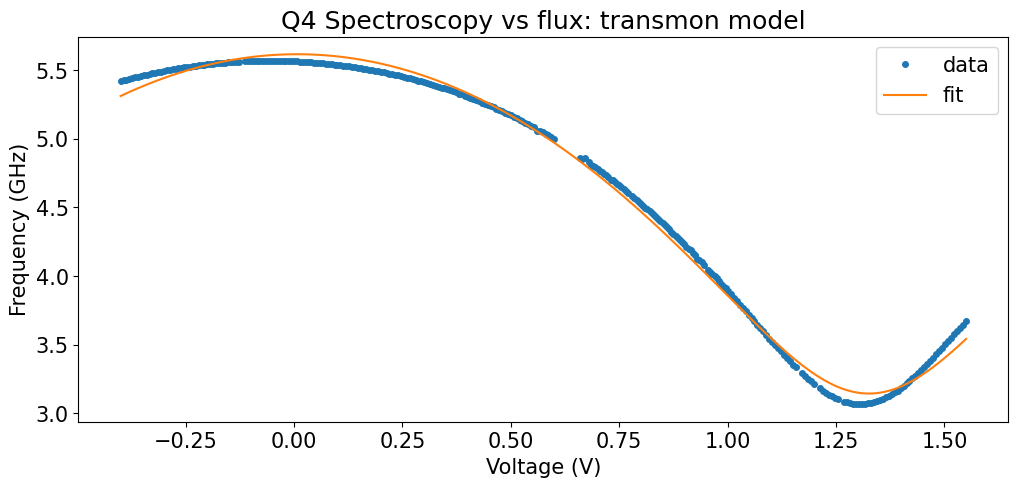

In [1090]:
spec_fit_qubits = ['Q2', 'Q3', 'Q4']
show_guess = False

for qubit in spec_fit_qubits:
    transmon_initial_guess = qubit_to_transmon_initial_guess[qubit]
    transmon_bounds = qubit_to_transmon_bounds[qubit]
    
    voltages = qubit_to_voltages[qubit]
    
    filtered_voltages = qubit_to_filtered_voltages[qubit]
    filtered_frequencies = qubit_to_filtered_frequencies[qubit]

    fit_voltages = np.linspace(voltages[0], voltages[-1], 1001)
    
    plt.plot(filtered_voltages, filtered_frequencies, marker='o', linestyle='', ms=4, label='data')
    
    if show_guess:
        plt.plot(fit_voltages, frequency_model_fit(fit_voltages, *transmon_initial_guess), label='guess')
    
    # fit
    transmon_popt, transmon_pcov = curve_fit(frequency_model_fit, filtered_voltages, filtered_frequencies, p0=transmon_initial_guess, bounds=transmon_bounds)
    print(transmon_popt)
    
    qubit_to_transmon_popts[qubit] = transmon_popt
    qubit_to_transmon_pcovs[qubit] = transmon_pcov

    plt.plot(fit_voltages, frequency_model_fit(fit_voltages, *transmon_popt), label='fit')
    
    plt.xlabel('Voltage (V)')
    plt.ylabel('Frequency (GHz)')

    plt.title(f'{qubit} Spectroscopy vs flux: transmon model')

    plt.legend()

    plt.show()

### 3.2 Trianglemon Model

In [1091]:
def frequency_model_fit_trianglemon(x, x0, a, b, c, d, e):
    
    EJ = np.sqrt(np.power(np.cos(b*(x-x0)),2) + (d**2)*np.power(np.sin(b*(x-x0)),2))
    
    return np.sqrt(a*EJ/(1+e*EJ)) - c/np.power(1+e*EJ, 3)

In [1092]:
# initial guesses
qubit_to_trianglemon_initial_guess = {}

qubit_to_trianglemon_initial_guess['Q2'] = list(qubit_to_transmon_initial_guess['Q2']) + [0.1]
qubit_to_trianglemon_initial_guess['Q2'][3] = 0.2006

qubit_to_trianglemon_initial_guess['Q3'] = list(qubit_to_transmon_initial_guess['Q3']) + [0.1]
qubit_to_trianglemon_initial_guess['Q3'][3] = 0.2004

qubit_to_trianglemon_initial_guess['Q4'] = list(qubit_to_transmon_initial_guess['Q4']) + [0.1]
qubit_to_trianglemon_initial_guess['Q4'][3] = 0.2002

# bounds
qubit_to_trianglemon_bounds = {}

qubit_to_trianglemon_bounds['Q2'] = ((-np.inf, 0, 0, 0.2005, 0, 0), (np.inf, np.inf, np.inf, 0.2006, 1, np.inf))
qubit_to_trianglemon_bounds['Q3'] = ((-np.inf, 0, 0, 0.2004, 0, 0), (np.inf, np.inf, np.inf, 0.2005, 1, np.inf))
qubit_to_trianglemon_bounds['Q4'] = ((-np.inf, 0, 0, 0.2002, 0, 0), (np.inf, np.inf, np.inf, 0.2003, 1, np.inf))



In [1093]:
# transmon popts, pcovs
qubit_to_trianglemon_popts = {}
qubit_to_trianglemon_err = {}


Q2:
	x0 = -2.53 +- 0.0007679990686687285
	a = 38.072 +- 0.9202011356353401
	b = 1.12 +- 0.0004931124972075487
	c = 0.201 +- 0.06815313202812882
	d = 0.408 +- 0.0030615575178914297
	e = 0.328 +- 0.019738823204690448


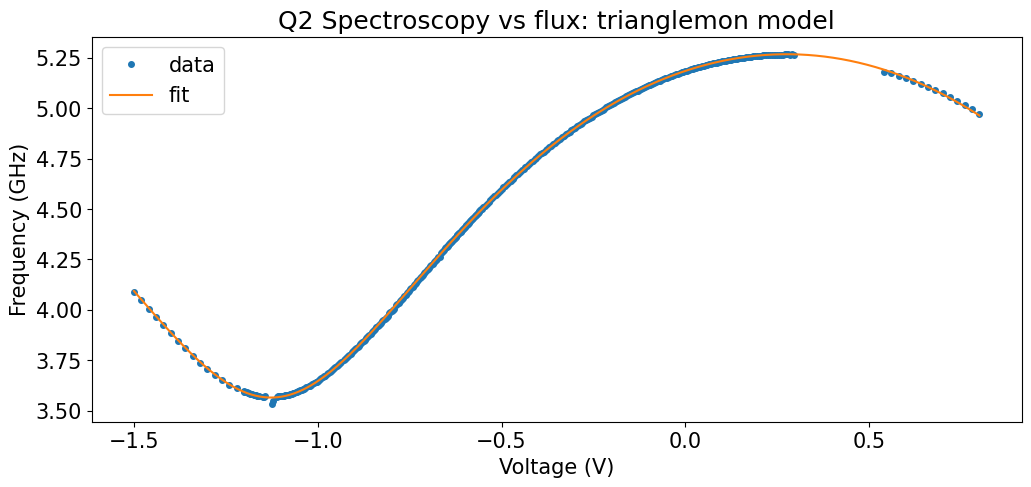

Q3:
	x0 = -0.387 +- 0.0006359496924435051
	a = 41.815 +- 1.6713540502433901
	b = 1.158 +- 0.0006534401372934047
	c = 0.2 +- 0.12382038763772941
	d = 0.383 +- 0.00564121200133372
	e = 0.407 +- 0.03645781039412429


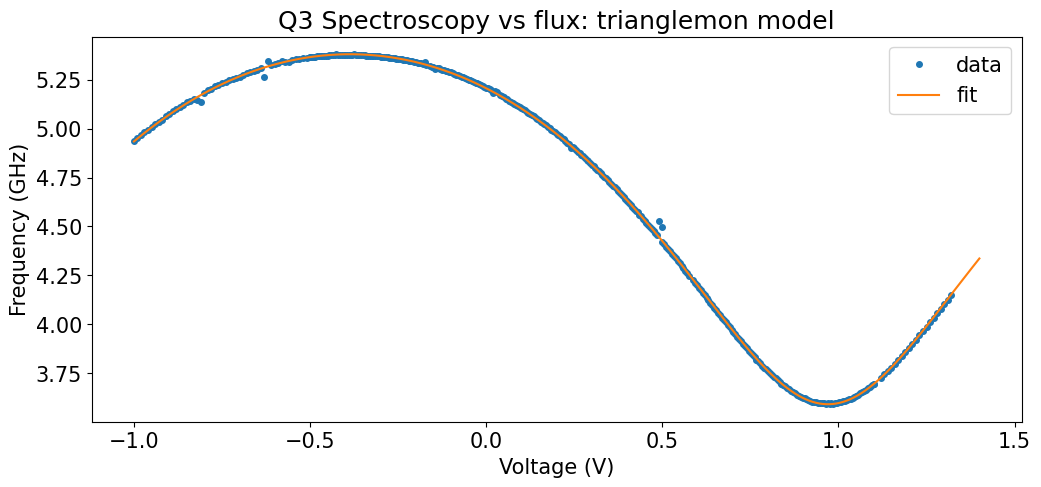

Q4:
	x0 = -0.051 +- 0.0006250009983903465
	a = 45.44 +- 0.4758720192226412
	b = 1.158 +- 0.0005445059099144192
	c = 0.2 +- 0.02902802416994774
	d = 0.251 +- 0.0013730759058518764
	e = 0.429 +- 0.010891694374735443


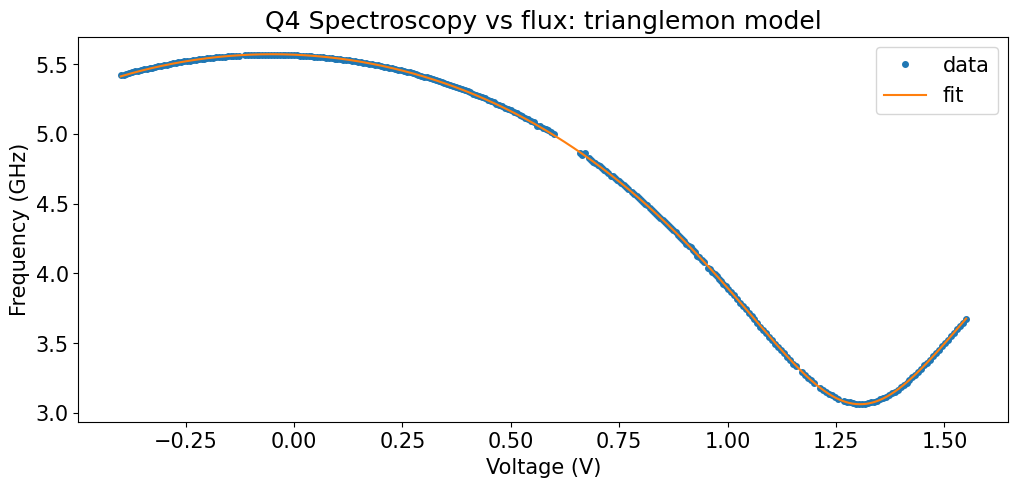

In [1094]:
spec_fit_qubits = ['Q2', 'Q3', 'Q4']
show_guess = False

for qubit in spec_fit_qubits:
    trianglemon_initial_guess = qubit_to_trianglemon_initial_guess[qubit]
    trianglemon_bounds = qubit_to_trianglemon_bounds[qubit]
    
    voltages = qubit_to_voltages[qubit]
    
    filtered_voltages = qubit_to_filtered_voltages[qubit]
    filtered_frequencies = qubit_to_filtered_frequencies[qubit]
    
    
    fit_voltages = np.linspace(voltages[0], voltages[-1], 1001)
    
    plt.plot(filtered_voltages, filtered_frequencies, marker='o', linestyle='', ms=4, label='data')
    
    if show_guess:
        plt.plot(fit_voltages, frequency_model_fit_trianglemon(fit_voltages, *trianglemon_initial_guess), label='guess')

    # fit
    trianglemon_popt, trianglemon_pcov = curve_fit(frequency_model_fit_trianglemon, filtered_voltages, filtered_frequencies, p0=trianglemon_initial_guess, bounds=trianglemon_bounds)
    
    qubit_to_trianglemon_popts[qubit] = trianglemon_popt

    plt.plot(fit_voltages, frequency_model_fit_trianglemon(fit_voltages, *trianglemon_popt), label='fit')
    
    # fit parameters
    trianglemon_err = np.sqrt(np.diag(trianglemon_pcov))
    qubit_to_trianglemon_err[qubit] = trianglemon_err

    fit_param_names = ['x0', 'a', 'b', 'c', 'd', 'e']

    print(f'{qubit}:')
    for i in range(len(fit_param_names)):
        print(f'\t{fit_param_names[i]} = {round(trianglemon_popt[i], 3)} +- {trianglemon_err[i]}')
        
    plt.xlabel('Voltage (V)')
    plt.ylabel('Frequency (GHz)')

    plt.title(f'{qubit} Spectroscopy vs flux: trianglemon model')

    plt.legend()

    plt.show()

### 3.3 Extract parameters

$$\omega = 2\pi\sqrt{\frac{8 E_c E_J}{1+\frac{L_g}{L_J}}} - \frac{E_c}{\left(1+\frac{L_g}{L_J}\right)^3}$$

$$L_J = \frac{\Phi_0^2}{(2\pi)^2E_J}$$

$$E_J = E_{J\text{max}}\sqrt{\cos^2{\left(\frac{\pi\Phi}{\Phi_0}\right)} + d^2\sin^2{\left(\frac{\pi\Phi}{\Phi_0}\right)}}$$

$$E_{J\text{max}} = E_{J1} + E_{J2}$$

$$d = \frac{E_{J2} - E_{J1}}{E_{J2} + E_{J1}}$$



Phase is current times mutual inductance
$$\Phi = MI$$ 

Relate to voltage
$$\Phi = \frac{MV}{R}$$ 

Flux quantum
$$\Phi_0 = \frac{h}{2e}$$

Rewrite
$$\omega = 2\pi\sqrt{\frac{8 E_c E_J}{1+\frac{L_g(2\pi)^2E_J}{\Phi_0^2}}} - \frac{E_c}{\left(1+\frac{L_g(2\pi)^2E_J}{\Phi_0^2}\right)^3}$$


$$\omega = 2\pi\sqrt{\frac{8 E_c E_{J\text{max}}\sqrt{\cos^2{\left(\frac{\pi MV}{\Phi_0R}\right)} + d^2\sin^2{\left(\frac{\pi MV}{\Phi_0R}\right)}}}{1+\frac{L_g(2\pi)^2E_{J\text{max}}\sqrt{\cos^2{\left(\frac{\pi MV}{\Phi_0R}\right)} + d^2\sin^2{\left(\frac{\pi MV}{\Phi_0R}\right)}}}{\Phi_0^2}}} - \frac{E_c}{\left(1+\frac{L_g(2\pi)^2E_{J\text{max}}\sqrt{\cos^2{\left(\frac{\pi MV}{\Phi_0R}\right)} + d^2\sin^2{\left(\frac{\pi MV}{\Phi_0R}\right)}}}{\Phi_0^2}\right)^3}$$

$$\omega = 2\pi\sqrt{\frac{a\sqrt{\cos^2{\left(b(V-x_0)\right)} + d^2\sin^2{\left(b(V-x_0)\right)}}}{1+e_1\sqrt{\cos^2{\left(b(V-x_0)\right)} + d^2\sin^2{\left(b(V-x_0)\right)}}}} - \frac{c}{\left(1+e_1\sqrt{\cos^2{\left(b(V-x_0)\right)} + d^2\sin^2{\left(b(V-x_0)\right)}}\right)^3}$$

$$a = 8E_cE_{J\text{max}}$$

$$b = \frac{\pi M}{\Phi_0 R}$$

$$c = E_c$$

$$e_1 = \frac{L_g (2\pi)^2E_{J\text{max}}}{\Phi_0^2}$$

In [1011]:
# define constants

h = 6.626e-34
hbar = h/(2*np.pi)
e = 1.6e-19 # Coulombs

Phi_0 = h/(2*e)


In [1095]:
extract_param_qubits = ['Q2', 'Q3','Q4']

qubit_to_Ec = {}
qubit_to_E_J_1 = {}
qubit_to_E_J_2 = {}
qubit_to_L_g = {}
qubit_to_L_g_err = {}

for qubit in extract_param_qubits:
    
    trianglemon_popt = qubit_to_trianglemon_popts[qubit]
    trianglemon_err = qubit_to_trianglemon_err[qubit]
    
    x0, a, b, c, d, e_1 = trianglemon_popt
    x0_err, a_err, b_err, c_err, d_err, e_1_err = trianglemon_err

    # x0 is phase offset
    # b has information about the mutual inductance and resistance of the fluxline
    # c has information about Ec
    # d has information aobut the percent difference between E_J1 and E_J2
    # e has information about the ratio of L_g to L_J

    print(f'{qubit}:')
    
    E_c = c
    qubit_to_Ec[qubit] = E_c
    print(f'\tE_c = {E_c*1e3} MHz')
    
    E_J_max = a/(8*E_c)
    print(f'\tE_J_max = {E_J_max} GHz')

    # EJ2 - EJ1 = d*E_J_max
    E_J_2 = (d+1)*E_J_max/2
    E_J_1 = (1-d)*E_J_max/2

    print(f'\tE_J_1 = {E_J_1} GHz')
    print(f'\tE_J_2 = {E_J_2} GHz')

    qubit_to_E_J_1[qubit] = E_J_1
    qubit_to_E_J_2[qubit] = E_J_2
    
    
    L_g = e_1*(Phi_0/(2*np.pi))**2/E_J_max/h
    L_g_err = e_1_err*(Phi_0/(2*np.pi))**2/E_J_max/h

    print(f'\n\tL_g = {round(L_g, 3)} nH +- {round(L_g_err, 3)} nH')
    print()
    
    qubit_to_L_g = L_g
    qubit_to_L_g_err = L_g_err



Q2:
	E_c = 200.59999999999997 MHz
	E_J_max = 23.723708204502014 GHz
	E_J_1 = 7.018987488481753 GHz
	E_J_2 = 16.70472071602026 GHz

	L_g = 2.268 nH +- 0.136 nH

Q3:
	E_c = 200.49999999999997 MHz
	E_J_max = 26.069115972406355 GHz
	E_J_1 = 8.044594323386535 GHz
	E_J_2 = 18.024521649019817 GHz

	L_g = 2.557 nH +- 0.229 nH

Q4:
	E_c = 200.29999999999998 MHz
	E_J_max = 28.357315682214242 GHz
	E_J_1 = 10.61921819392876 GHz
	E_J_2 = 17.73809748828548 GHz

	L_g = 2.479 nH +- 0.063 nH



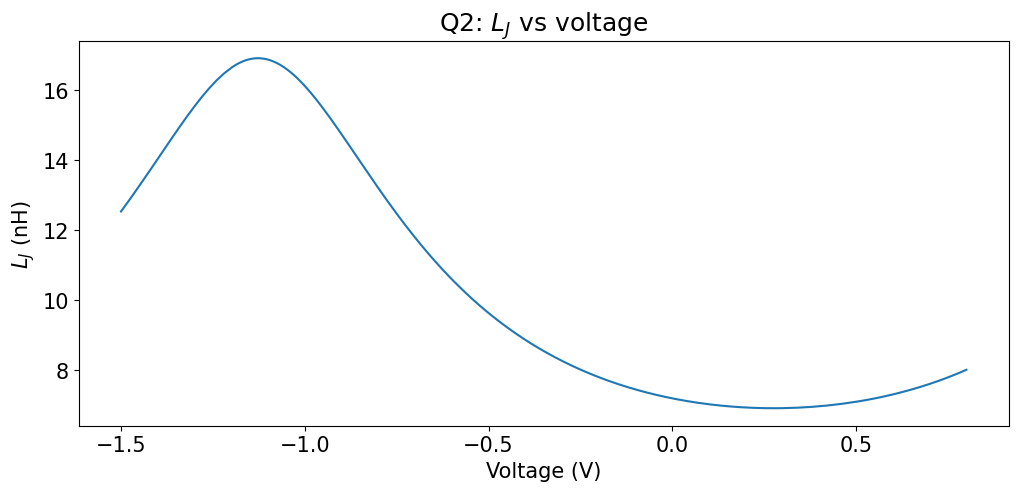

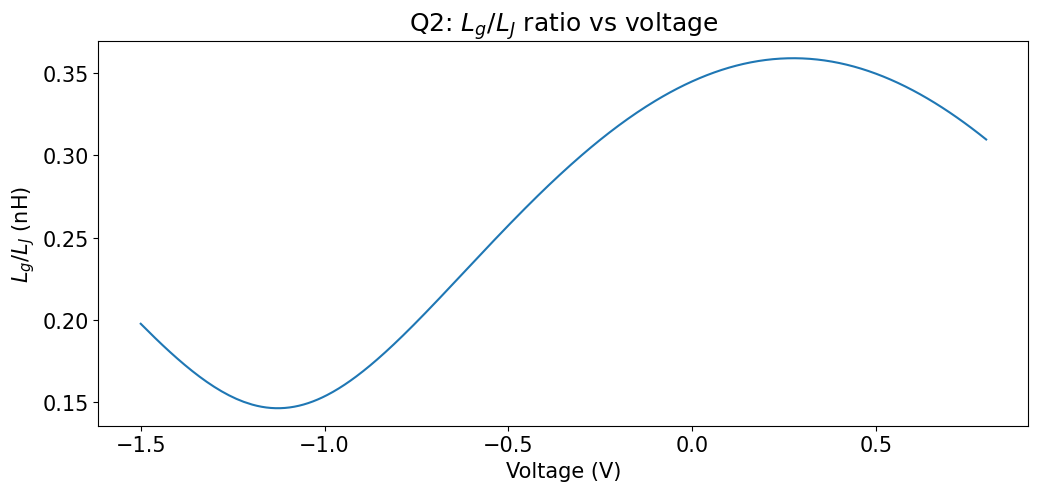

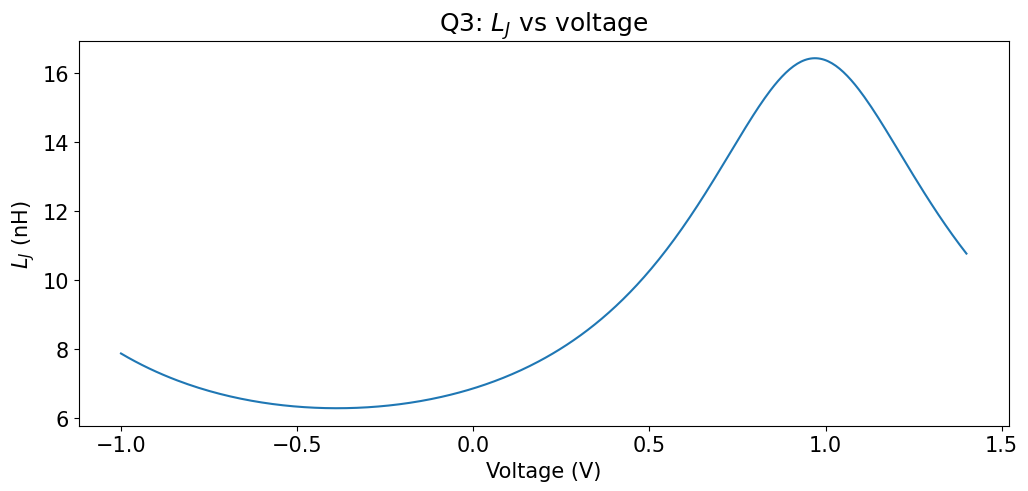

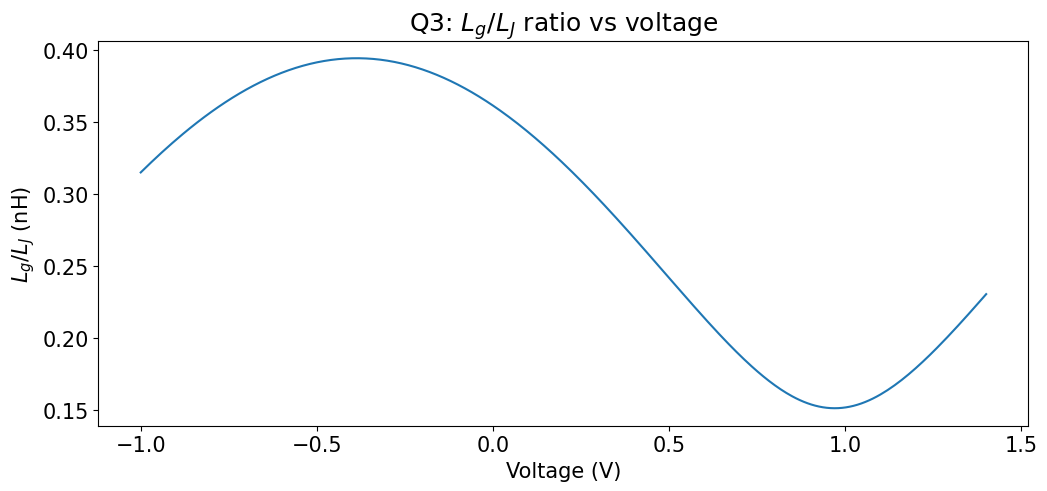

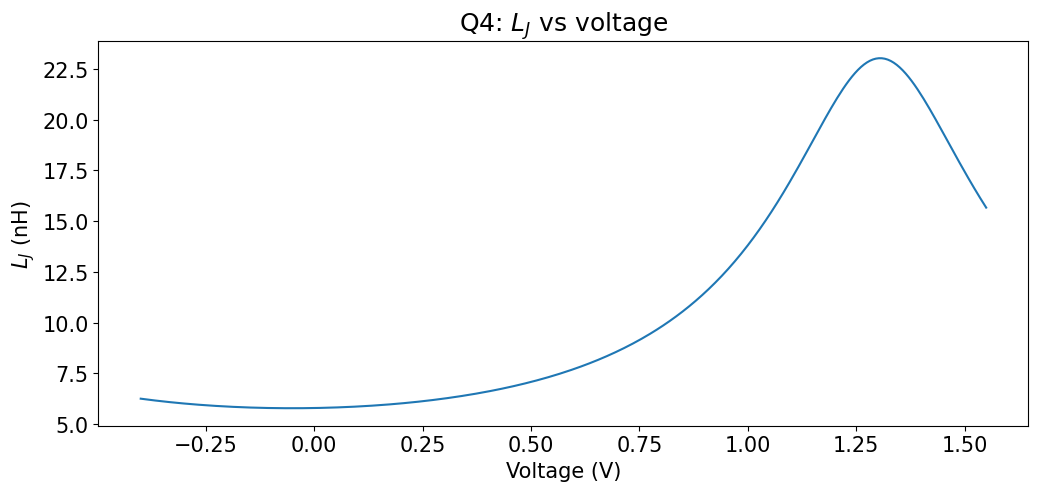

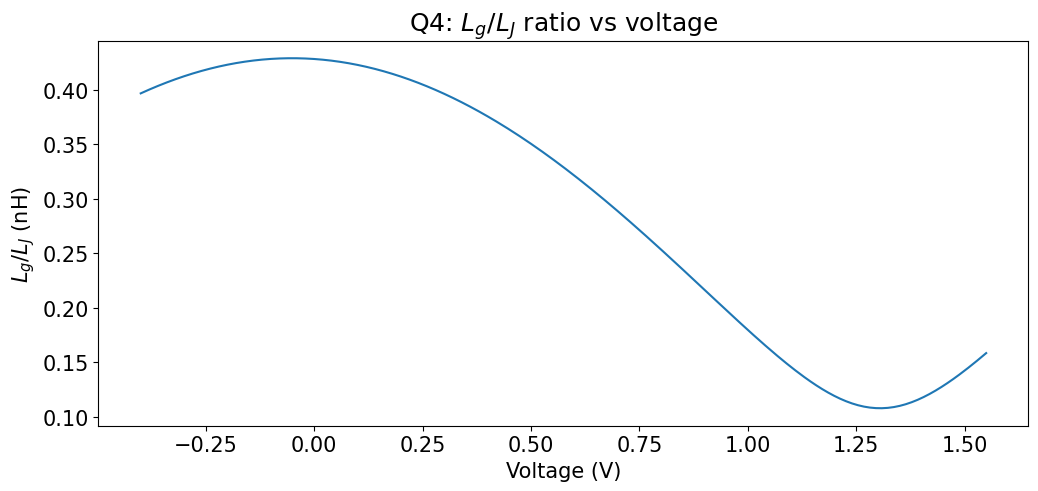

In [1096]:
### plot LJ vs voltage
for qubit in extract_param_qubits:
    
    trianglemon_popt = qubit_to_trianglemon_popts[qubit]
    trianglemon_err = qubit_to_trianglemon_err[qubit]
    
    voltages = qubit_to_voltages[qubit]
    
    x0, a, b, c, d, e_1 = trianglemon_popt
    
    E_J_1 = qubit_to_E_J_1[qubit]
    E_J_2 = qubit_to_E_J_2[qubit]
    E_J_max = E_J_1 + E_J_2
    
    E_J = lambda V: E_J_max*np.sqrt(np.power(np.cos(b*(V-x0)),2) + (d**2)*np.power(np.sin(b*(V-x0)),2))
    L_J = lambda V: (Phi_0/(2*np.pi))**2/E_J(V)/h

    plt.plot(voltages, L_J(voltages))

    plt.xlabel('Voltage (V)')
    plt.ylabel('$L_J$ (nH)')

    plt.title(f'{qubit}: $L_J$ vs voltage')
    plt.show()

    plt.plot(voltages, L_g/L_J(voltages))

    plt.xlabel('Voltage (V)')
    plt.ylabel('$L_g$/$L_J$ (nH)')

    plt.title(f'{qubit}: $L_g$/$L_J$ ratio vs voltage')
    plt.show()

In [1108]:
### flux quantum / voltage period factor


for qubit in extract_param_qubits:
    
    trianglemon_popt = qubit_to_trianglemon_popts[qubit]
    trianglemon_err = qubit_to_trianglemon_err[qubit]
    
    x0, a, b, c, d, e_1 = trianglemon_popt
    x0_err, a_err, b_err, c_err, d_err, e_1_err = trianglemon_err
    
    print(f'{qubit} voltage period: {round(np.pi/b, 3)} V')

Q2 voltage period: 2.805 V
Q3 voltage period: 2.714 V
Q4 voltage period: 2.713 V


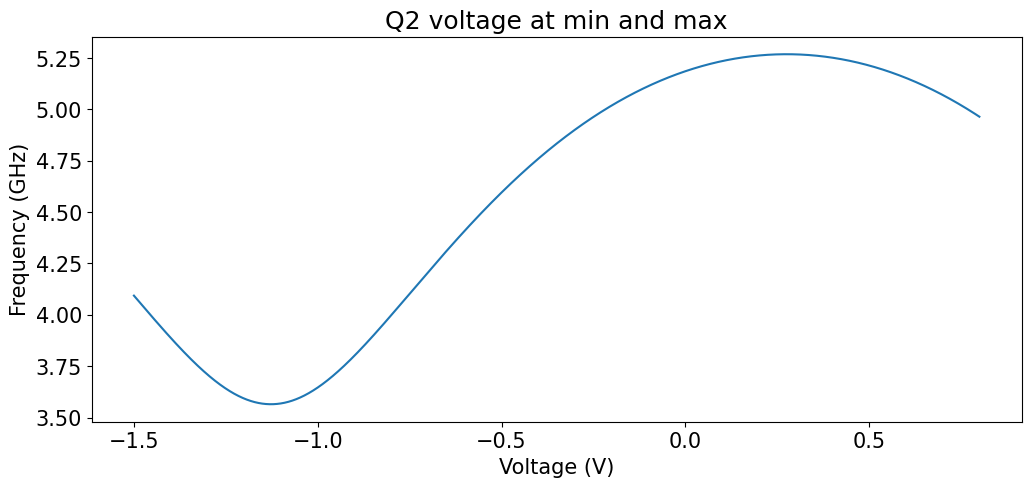

Q2 voltage at min: -1.127 V
Q2 voltage at max: 0.276 V



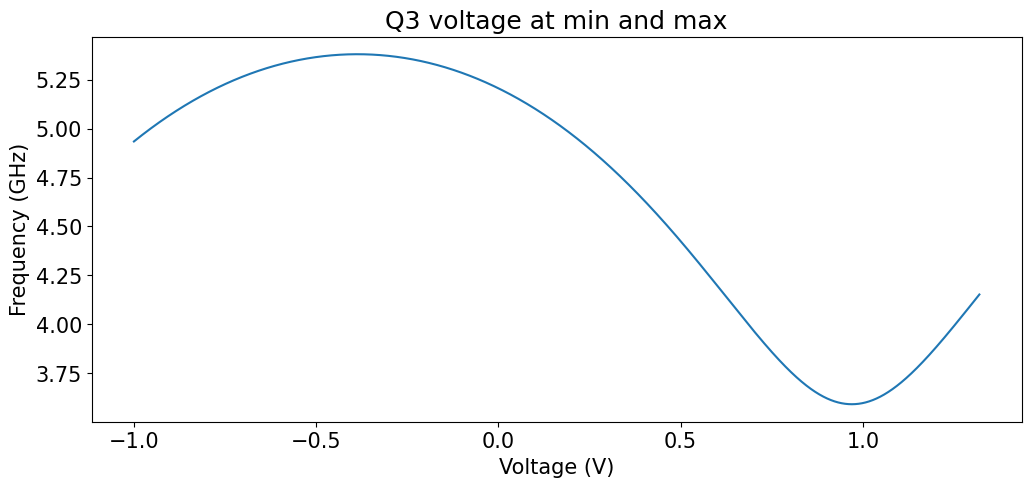

Q3 voltage at min: 0.97 V
Q3 voltage at max: -0.387 V



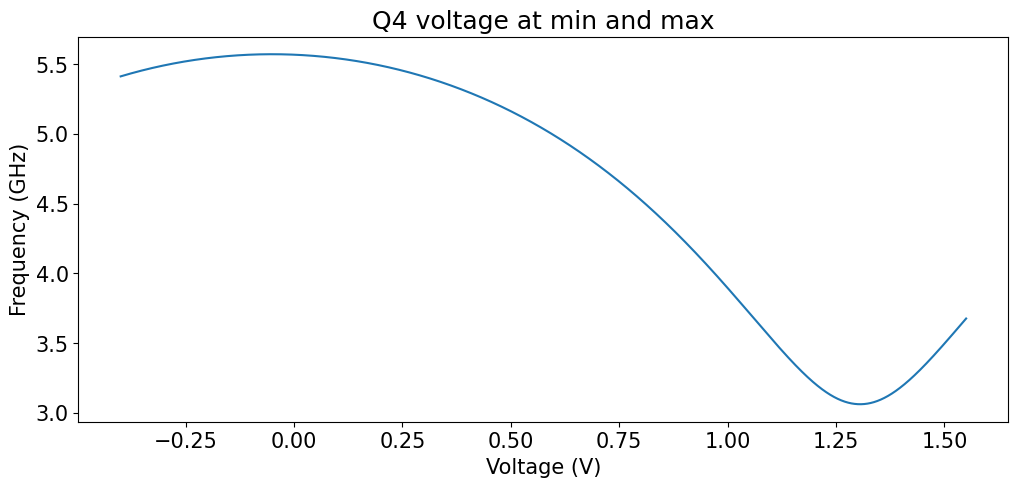

Q4 voltage at min: 1.305 V
Q4 voltage at max: -0.051 V



In [1203]:
### voltage at min/max

for qubit in extract_param_qubits:
    
    trianglemon_popt = qubit_to_trianglemon_popts[qubit]
    filtered_voltages = qubit_to_filtered_voltages[qubit]
    
    if qubit == 'Q2':
        fit_voltages = np.linspace(filtered_voltages[0], filtered_voltages[-1], 10001)
    elif qubit == 'Q3':
        fit_voltages = np.linspace(filtered_voltages[0], filtered_voltages[-1], 10001)
    else:
        fit_voltages = np.linspace(filtered_voltages[0], filtered_voltages[-1], 10001)
    fit_frequnecies = frequency_model_fit_trianglemon(fit_voltages, *trianglemon_popt)
    
    plt.plot(fit_voltages, fit_frequnecies)
    plt.xlabel('Voltage (V)')
    plt.ylabel('Frequency (GHz)')
    
    plt.title(f'{qubit} voltage at min and max')
    
    plt.show()
    
    print(f'{qubit} voltage at min: {round(fit_voltages[np.argmin(fit_frequnecies)], 3)} V')
    print(f'{qubit} voltage at max: {round(fit_voltages[np.argmax(fit_frequnecies)], 3)} V') 
    print()

### 3.4 Define functions for frequencies vs flux

In [1205]:
qubit_to_function = {}

function_qubits = ['Q2', 'Q3', 'Q4']
# function_qubits = ['Q4']

for qubit in function_qubits:
    
    trianglemon_popt = qubit_to_trianglemon_popts[qubit]
    fit_frequnecies = frequency_model_fit_trianglemon(fit_voltages, *trianglemon_popt)
    
    x0, a, b, c, d, e_1 = trianglemon_popt
    
    print(trianglemon_popt)
    # takes a flux value and outputs frequency
    print(qubit)
    
    def create_qubit_function(popt):
        x0, a, b, c, d, e_1 = popt
        return lambda x: frequency_model_fit_trianglemon((np.pi*x)/b + x0, *popt)
    
    qubit_to_function[qubit] = create_qubit_function(trianglemon_popt)
    
frequency_vs_flux_q2 = qubit_to_function['Q2']
frequency_vs_flux_q3 = qubit_to_function['Q3']
frequency_vs_flux_q4 = qubit_to_function['Q4']

[-2.52987141 38.07180693  1.11984416  0.2006      0.40827231  0.3283082 ]
Q2
[-0.38698604 41.81486202  1.15753531  0.2005      0.38282569  0.40663667]
Q3
[-0.0511357  45.43976265  1.15793044  0.2003      0.25104207  0.42895391]
Q4


In [1206]:
print(qubit_to_function)

{'Q2': <function create_qubit_function.<locals>.<lambda> at 0x000002795A433C70>, 'Q3': <function create_qubit_function.<locals>.<lambda> at 0x000002795A432830>, 'Q4': <function create_qubit_function.<locals>.<lambda> at 0x000002795DCDAB00>}


In [1207]:
print(f'Q2: {frequency_vs_flux_q2(0.2977646407840279)} GHz')
print(f'Q3: {frequency_vs_flux_q3(-0.20959051036485465)} GHz')
print(f'Q4: {frequency_vs_flux_q4(-0.39692517561248286)} GHz')

Q2: 4.486143871781226 GHz
Q3: 4.9980502786592025 GHz
Q4: 3.8026929334738484 GHz


In [ ]:
Q2: 4.911436175856207 GHz
Q3: 4.630835081294038 GHz 
Q4: 5.469147990889586 GHz

In [1210]:
print(f'Q2: {frequency_vs_flux_q2(-0.20223535921597208)} GHz')
print(f'Q3: {frequency_vs_flux_q3(0.27418845576705264)} GHz')
print(f'Q4: {frequency_vs_flux_q4(0.10289059446857833)} GHz')

Q2: 4.911436175856207 GHz
Q3: 4.71474464548929 GHz
Q4: 5.469514508252519 GHz


In [1211]:
print(f'Q2: {frequency_vs_flux_q2(-0.38342245989304813)} GHz')
print(f'Q3: {frequency_vs_flux_q3(0.35904381716510547)} GHz')
print(f'Q4: {frequency_vs_flux_q4(0.33534183348766183)} GHz')

Q2: 3.9977054006679626 GHz
Q3: 4.228140392413124 GHz
Q4: 4.358086322137996 GHz


In [1213]:
print(f'Q4: {frequency_vs_flux_q4(0.35071129700524467)} GHz')

Q4: 4.2296482999506075 GHz


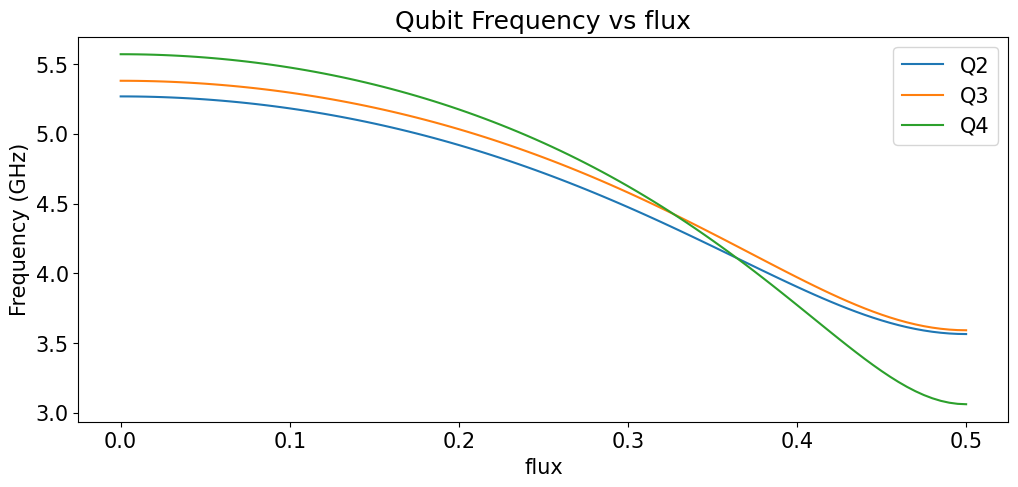

In [1209]:
test_fluxes = np.linspace(0, 0.5, 101)

plt.plot(test_fluxes, frequency_vs_flux_q2(test_fluxes), label='Q2')
plt.plot(test_fluxes, frequency_vs_flux_q3(test_fluxes), label='Q3')
plt.plot(test_fluxes, frequency_vs_flux_q4(test_fluxes), label='Q4')

plt.xlabel('flux')
plt.ylabel('Frequency (GHz)')

plt.legend()

plt.title('Qubit Frequency vs flux')
plt.show()